In [1]:
from __future__ import print_function
import mxnet as mx
import numpy as np
import optimizer
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from mxnet.gluon.data import DataLoader, ArrayDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
%matplotlib inline
def set_seed(seed):
    np.random.seed(seed)
    mx.random.seed(seed)

In [33]:
def get_data(dataset):    
    data = pd.read_csv("dataset/"+dataset, header=0)
    y, X = np.array(data.iloc[:,-1]).reshape(-1,1), np.array(data.iloc[:,0:-1])
    y[y==0]=-1
    print(X.shape); print(y.shape)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, 
     #                                                   test_size = 0.2, random_state=0)
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_x.fit(X)
    scaler_y.fit(y)

    X = scaler_x.transform(X)
    y = scaler_y.transform(y)
    return X,y

X,y=get_data('Residential_Building.csv')
X_tr=X[:200,:]
X_te=X[200:,:]
y_tr=y[:200,:]
y_te=y[200:,:]

(372, 107)
(372, 1)


In [34]:
X_tr

array([[-0.11585516, -1.10068651,  0.48560492, ..., -0.68678946,
         1.02644911, -0.54734304],
       [ 0.60244684, -1.10068651,  1.43387279, ...,  1.27751817,
         1.2804107 ,  0.09891459],
       [-0.83415716, -1.10068651, -0.46266295, ..., -0.99664143,
         0.76907963, -0.9903018 ],
       ...,
       [ 0.36301284,  0.74787052,  0.48560492, ...,  0.71954847,
        -0.38037809, -0.08986597],
       [-0.83415716, -0.176408  , -0.69972992, ..., -1.00862914,
        -1.31762083, -0.93883184],
       [-0.35528916,  0.74787052, -0.22559599, ..., -0.78529583,
        -0.50735889, -0.54003034]])

In [35]:
data_ctx = mx.cpu()
#model_ctx = mx.cpu()
model_ctx = mx.gpu(2)

In [36]:
batch_size=1
train_dataset = ArrayDataset(nd.array(X_tr), nd.array(y_tr))
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,last_batch='discard')


In [80]:
ctx=model_ctx
epochs = 24
Xtr_nd = nd.array(X_tr).as_in_context(ctx)
ytr_nd = nd.array(y_tr).as_in_context(ctx)
Xte_nd = nd.array(X_te).as_in_context(ctx)
yte_nd = nd.array(y_te).as_in_context(ctx)
metric = mx.metric.Accuracy()
loss_function = gluon.loss.L2Loss()

In [62]:
def trainLA(optimizername):
    set_seed(1)
    net=nn.Sequential()
    net.add(nn.Dense(1, activation=None))
    net.initialize(mx.init.MSRAPrelu(), ctx=ctx)
    for i, (data, label) in enumerate(train_data):
        aa=net(data.as_in_context(ctx))
        break
    trainer1 = gluon.Trainer(
        net.collect_params(),
        optimizername,
        {'learning_rate': 0.001 } 
    )
    
    trainer2 = gluon.Trainer(
        net.collect_params(),
        'lookahead'+optimizername,
        {'learning_rate': 0.001 ,'k':10, 'alpha':0.5} 
    )    

    LASGD_trainerr=[]
    LASGD_testacc=[]
    iteration=0

    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
           # print(i)
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss=loss_function(output, label)
            loss.backward()
            iteration+=1
            if iteration<300:
                trainer1.step(batch_size)
            else:
                trainer2.step(batch_size)
                
            cumulative_loss += nd.mean(loss).asscalar()
            trainloss=nd.mean(loss_function(net(Xtr_nd),ytr_nd)).asscalar()
            LASGD_trainerr.append(trainloss)
            testacc=nd.mean(loss_function(net(Xte_nd),yte_nd)).asscalar()
            LASGD_testacc.append(testacc)
            print('trainloss:',trainloss,'testacc',testacc)

        if e%1==0:
            print(e)
    return LASGD_testacc,LASGD_trainerr

In [63]:
def train(optimizername):
    ctx=model_ctx
    set_seed(1)
    net=nn.Sequential()
    net.add(nn.Dense(1, activation=None))
    net.initialize(mx.init.MSRAPrelu(), ctx=ctx)
    #net[1].initialize(mx.initializer.One(),ctx=ctx,force_reinit=True)
    for i, (data, label) in enumerate(train_data):
        #print(data.dtpye)
        aa=net(data.as_in_context(ctx))
        break
    #optimizer.LookaheadSGD(k=5, alpha=0.5, learning_rate=1e-3)
    trainer = gluon.Trainer(
        net.collect_params(),
        optimizername,
        {'learning_rate': 0.001 },
    #    optimizer_params = {'learning_rate': 0.01,'beta1': 0.9} , 
    )
    
    SGD_trainerr=[]
    SGD_testacc=[]

    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
           # print(i)
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss=loss_function(output, label)
            loss.backward()
            trainer.step(batch_size)#,ignore_stale_grad=True) ###ignore
            cumulative_loss += nd.mean(loss).asscalar()
            trainloss=nd.mean(loss_function(net(Xtr_nd),ytr_nd)).asscalar()
            SGD_trainerr.append(trainloss)
            testacc=nd.mean(loss_function(net(Xte_nd),yte_nd)).asscalar()
            SGD_testacc.append(testacc)
            print('trainloss:',trainloss,'testacc',testacc)

        if e%1==0:
            print(e)
    return SGD_testacc, SGD_trainerr

In [81]:
for i in ['sgd','adam','rmsprop']:
    exec(i+"te,"+i+"tr=train('"+i+"')") 
    exec("LA"+i+"te,"+"LA"+i+"tr=trainLA('"+i+"')") 

trainloss: 0.95416784 testacc 0.42913207
trainloss: 0.94292396 testacc 0.4289112
trainloss: 0.93544745 testacc 0.426855
trainloss: 0.9343565 testacc 0.4267818
trainloss: 0.9308596 testacc 0.42497492
trainloss: 0.92337644 testacc 0.42105156
trainloss: 0.89678115 testacc 0.41401312
trainloss: 0.87006956 testacc 0.40868962
trainloss: 0.82145727 testacc 0.44809684
trainloss: 0.8215479 testacc 0.44600224
trainloss: 0.8276989 testacc 0.4159437
trainloss: 0.82814616 testacc 0.4154424
trainloss: 0.8251941 testacc 0.41594857
trainloss: 0.81087565 testacc 0.41727695
trainloss: 0.92141783 testacc 0.3879844
trainloss: 0.8049028 testacc 0.386944
trainloss: 0.79892075 testacc 0.3893016
trainloss: 0.7935582 testacc 0.38716525
trainloss: 0.7959286 testacc 0.38517272
trainloss: 0.78294665 testacc 0.38554266
trainloss: 0.77498436 testacc 0.4485728
trainloss: 0.7765196 testacc 0.47658733
trainloss: 0.77301764 testacc 0.45769376
trainloss: 0.78399354 testacc 0.522287
trainloss: 0.80500734 testacc 0.570625

trainloss: 0.3573128 testacc 0.23548652
trainloss: 0.3567004 testacc 0.23467763
trainloss: 0.35665676 testacc 0.23429118
trainloss: 0.41384757 testacc 0.3546356
trainloss: 0.39935967 testacc 0.33050236
trainloss: 0.39847514 testacc 0.32901984
trainloss: 0.34174865 testacc 0.17720905
trainloss: 0.3905472 testacc 0.169335
trainloss: 0.40730336 testacc 0.17368664
trainloss: 0.3993162 testacc 0.17155929
trainloss: 0.38707465 testacc 0.16844036
trainloss: 0.3834407 testacc 0.16772127
trainloss: 0.39114368 testacc 0.17069697
trainloss: 0.39047763 testacc 0.16914333
trainloss: 0.37759617 testacc 0.16684513
trainloss: 0.3771767 testacc 0.16549534
trainloss: 0.34305406 testacc 0.16866808
trainloss: 0.33648396 testacc 0.17417148
trainloss: 0.33819592 testacc 0.17229842
trainloss: 0.34008515 testacc 0.17067775
trainloss: 0.33762726 testacc 0.17242834
trainloss: 0.34176394 testacc 0.16801979
trainloss: 0.34214607 testacc 0.16794586
trainloss: 0.34471095 testacc 0.1661825
trainloss: 0.34957072 test

trainloss: 0.23667572 testacc 0.1394067
trainloss: 0.23726366 testacc 0.1383463
trainloss: 0.23597643 testacc 0.14065658
trainloss: 0.23680982 testacc 0.1390708
trainloss: 0.23521295 testacc 0.14230552
trainloss: 0.23904121 testacc 0.13480742
trainloss: 0.23779336 testacc 0.13642393
trainloss: 0.23393135 testacc 0.14529288
trainloss: 0.23865473 testacc 0.13557518
trainloss: 0.23765388 testacc 0.13690008
trainloss: 0.23547378 testacc 0.1408702
trainloss: 0.23628704 testacc 0.13763008
trainloss: 0.23516884 testacc 0.13981475
trainloss: 0.23784353 testacc 0.13465905
trainloss: 0.23720399 testacc 0.13550149
trainloss: 0.2366597 testacc 0.13633081
trainloss: 0.23956183 testacc 0.13313593
trainloss: 0.23291862 testacc 0.14408183
trainloss: 0.23309788 testacc 0.14323655
trainloss: 0.23516865 testacc 0.18220891
trainloss: 0.23705713 testacc 0.18819995
trainloss: 0.23692437 testacc 0.18742366
trainloss: 0.23947328 testacc 0.19495815
trainloss: 0.23901281 testacc 0.19431879
trainloss: 0.23878303

trainloss: 0.18085039 testacc 0.16174492
trainloss: 0.18116747 testacc 0.16302757
trainloss: 0.18472874 testacc 0.17462501
trainloss: 0.1772675 testacc 0.14759742
trainloss: 0.17728382 testacc 0.14783904
trainloss: 0.17719956 testacc 0.13499822
trainloss: 0.17967744 testacc 0.16781007
trainloss: 0.17865352 testacc 0.16455339
trainloss: 0.18015854 testacc 0.16962598
trainloss: 0.1819456 testacc 0.17475034
trainloss: 0.17509352 testacc 0.1283988
trainloss: 0.17612462 testacc 0.1253632
trainloss: 0.17242965 testacc 0.13602607
trainloss: 0.1723998 testacc 0.14138961
trainloss: 0.17253195 testacc 0.14402713
trainloss: 0.17207259 testacc 0.13496779
trainloss: 0.17517717 testacc 0.16020197
trainloss: 0.17721492 testacc 0.1670249
trainloss: 0.17861645 testacc 0.17077562
trainloss: 0.1722901 testacc 0.14918098
trainloss: 0.17074226 testacc 0.13984753
trainloss: 0.17114969 testacc 0.14351298
trainloss: 0.17113827 testacc 0.14324637
trainloss: 0.17105892 testacc 0.14286411
trainloss: 0.17183441 t

trainloss: 0.14893305 testacc 0.14564243
trainloss: 0.14865956 testacc 0.14494964
trainloss: 0.14330667 testacc 0.12978676
trainloss: 0.1432972 testacc 0.12945549
trainloss: 0.14350839 testacc 0.13332103
trainloss: 0.1431994 testacc 0.12878221
trainloss: 0.14345825 testacc 0.13498698
trainloss: 0.14426781 testacc 0.11426942
trainloss: 0.14356273 testacc 0.11619038
trainloss: 0.15157029 testacc 0.10551044
trainloss: 0.14886266 testacc 0.10693636
trainloss: 0.14864542 testacc 0.10712072
trainloss: 0.14417367 testacc 0.1130397
trainloss: 0.14416826 testacc 0.11311677
trainloss: 0.14410499 testacc 0.113244236
trainloss: 0.14578232 testacc 0.11022679
trainloss: 0.14612924 testacc 0.109898746
trainloss: 0.14556135 testacc 0.11074302
trainloss: 0.14487633 testacc 0.111701176
trainloss: 0.14472449 testacc 0.11198802
trainloss: 0.14378704 testacc 0.11353652
trainloss: 0.14464766 testacc 0.11152815
trainloss: 0.14885412 testacc 0.10663334
trainloss: 0.14958912 testacc 0.10607333
trainloss: 0.150

trainloss: 0.14300439 testacc 0.1618662
trainloss: 0.14399396 testacc 0.1636344
trainloss: 0.13558826 testacc 0.14669152
trainloss: 0.12335875 testacc 0.11602104
trainloss: 0.12433134 testacc 0.11989975
trainloss: 0.12465011 testacc 0.12079329
trainloss: 0.12266077 testacc 0.11494418
trainloss: 0.12806979 testacc 0.13296328
trainloss: 0.12783319 testacc 0.13265857
trainloss: 0.12261506 testacc 0.115619086
trainloss: 0.12126538 testacc 0.10840416
trainloss: 0.12135759 testacc 0.109046735
trainloss: 0.122233674 testacc 0.1138874
trainloss: 0.12083734 testacc 0.10385152
trainloss: 0.12016494 testacc 0.10515009
trainloss: 0.120086215 testacc 0.10558074
trainloss: 0.1198639 testacc 0.11146779
trainloss: 0.122931354 testacc 0.09727671
trainloss: 0.1228405 testacc 0.09680149
trainloss: 0.11975097 testacc 0.10348549
trainloss: 0.11926388 testacc 0.1093414
trainloss: 0.119319946 testacc 0.10717109
trainloss: 0.11928566 testacc 0.10772403
trainloss: 0.11926985 testacc 0.10853736
trainloss: 0.119

trainloss: 0.107541345 testacc 0.105860986
trainloss: 0.107688084 testacc 0.10890607
trainloss: 0.10755352 testacc 0.108636715
trainloss: 0.10879465 testacc 0.11640285
trainloss: 0.10912694 testacc 0.1178025
trainloss: 0.107187174 testacc 0.106770486
trainloss: 0.10754097 testacc 0.11028985
trainloss: 0.10749464 testacc 0.10995016
trainloss: 0.10752815 testacc 0.110199355
trainloss: 0.107158214 testacc 0.102421835
trainloss: 0.107183486 testacc 0.10218739
trainloss: 0.10735998 testacc 0.100859165
trainloss: 0.1074132 testacc 0.09966634
trainloss: 0.10836431 testacc 0.09604751
trainloss: 0.10859707 testacc 0.09552675
trainloss: 0.10769749 testacc 0.09767903
trainloss: 0.10676101 testacc 0.10167305
trainloss: 0.107249126 testacc 0.09864173
trainloss: 0.107071124 testacc 0.099129446
trainloss: 0.106732376 testacc 0.10137245
trainloss: 0.11032631 testacc 0.12533633
trainloss: 0.10618885 testacc 0.10390463
trainloss: 0.10621251 testacc 0.10287141
trainloss: 0.10622805 testacc 0.102434605
tr

trainloss: 0.096021816 testacc 0.09518657
trainloss: 0.09633316 testacc 0.09993862
trainloss: 0.096368335 testacc 0.10026291
trainloss: 0.09685102 testacc 0.10272439
trainloss: 0.096910745 testacc 0.10301539
trainloss: 0.09602811 testacc 0.09209128
trainloss: 0.0960456 testacc 0.09197919
trainloss: 0.09634106 testacc 0.09059365
trainloss: 0.09745769 testacc 0.087981515
trainloss: 0.09732086 testacc 0.08823711
trainloss: 0.095515124 testacc 0.09464293
trainloss: 0.09552206 testacc 0.096670225
trainloss: 0.095747754 testacc 0.09198414
trainloss: 0.095758446 testacc 0.091928855
trainloss: 0.09583718 testacc 0.091546625
trainloss: 0.09544343 testacc 0.09631289
trainloss: 0.10023895 testacc 0.084170096
trainloss: 0.09458517 testacc 0.09184704
trainloss: 0.094453126 testacc 0.09193657
trainloss: 0.094271205 testacc 0.098949075
trainloss: 0.094257966 testacc 0.09886556
trainloss: 0.09417091 testacc 0.09841918
trainloss: 0.09405563 testacc 0.097952686
trainloss: 0.09397894 testacc 0.097276025


trainloss: 0.086841434 testacc 0.10102501
trainloss: 0.08562523 testacc 0.09719563
trainloss: 0.087374076 testacc 0.102690056
trainloss: 0.087777995 testacc 0.10360823
trainloss: 0.0884178 testacc 0.10515826
trainloss: 0.08993104 testacc 0.108655274
trainloss: 0.08928847 testacc 0.107254416
trainloss: 0.090954706 testacc 0.11096616
trainloss: 0.08537588 testacc 0.09561232
trainloss: 0.083948284 testacc 0.088083945
trainloss: 0.08407078 testacc 0.089383155
trainloss: 0.083725415 testacc 0.08784581
trainloss: 0.08370481 testacc 0.08793424
trainloss: 0.08385392 testacc 0.08957508
trainloss: 0.08411819 testacc 0.091257736
trainloss: 0.08410063 testacc 0.09113058
trainloss: 0.08406563 testacc 0.091281645
trainloss: 0.08466687 testacc 0.09426006
trainloss: 0.08527265 testacc 0.09640001
trainloss: 0.08462544 testacc 0.09413809
trainloss: 0.08366829 testacc 0.08980293
trainloss: 0.084349304 testacc 0.09296739
trainloss: 0.08456667 testacc 0.09383836
trainloss: 0.084279 testacc 0.09271593
train

trainloss: 0.07987495 testacc 0.0714994
trainloss: 0.07895765 testacc 0.073063985
trainloss: 0.078888185 testacc 0.07287655
trainloss: 0.078227445 testacc 0.07593774
trainloss: 0.07902788 testacc 0.072346896
trainloss: 0.078816056 testacc 0.072946146
trainloss: 0.078836925 testacc 0.07285614
trainloss: 0.07861399 testacc 0.073556416
trainloss: 0.07819468 testacc 0.07763115
trainloss: 0.078559525 testacc 0.07307081
trainloss: 0.078140736 testacc 0.074708104
trainloss: 0.07833868 testacc 0.07341362
trainloss: 0.07794219 testacc 0.07518861
trainloss: 0.07792581 testacc 0.07531751
trainloss: 0.07810115 testacc 0.07377736
trainloss: 0.07792137 testacc 0.07806282
trainloss: 0.077840365 testacc 0.07685009
trainloss: 0.07862026 testacc 0.0712296
trainloss: 0.08057222 testacc 0.069023035
trainloss: 0.079479195 testacc 0.06983988
trainloss: 0.07895521 testacc 0.07039611
trainloss: 0.07914227 testacc 0.07003664
trainloss: 0.07765576 testacc 0.07382637
trainloss: 0.07807596 testacc 0.071947955
tra

trainloss: 0.07005047 testacc 0.068979986
trainloss: 0.073003866 testacc 0.06551879
trainloss: 0.073388174 testacc 0.06540493
trainloss: 0.07192556 testacc 0.065994374
trainloss: 0.07195235 testacc 0.065892935
trainloss: 0.07249283 testacc 0.0655203
trainloss: 0.07159113 testacc 0.06597984
trainloss: 0.07241918 testacc 0.06531101
trainloss: 0.0747395 testacc 0.0645974
trainloss: 0.07336643 testacc 0.06486057
trainloss: 0.06930934 testacc 0.07129995
trainloss: 0.07090074 testacc 0.07863617
trainloss: 0.07118427 testacc 0.0793453
trainloss: 0.07118262 testacc 0.079342246
trainloss: 0.06993191 testacc 0.07567308
trainloss: 0.06966753 testacc 0.07460279
trainloss: 0.069771774 testacc 0.075104356
trainloss: 0.06996386 testacc 0.07586539
trainloss: 0.07599719 testacc 0.06468863
trainloss: 0.07801547 testacc 0.06487071
trainloss: 0.07785181 testacc 0.06485129
trainloss: 0.07774861 testacc 0.064835526
trainloss: 0.076947495 testacc 0.064845465
trainloss: 0.071112126 testacc 0.06582707
trainlos

trainloss: 0.06417359 testacc 0.06960635
trainloss: 0.06600983 testacc 0.07588607
trainloss: 0.066269346 testacc 0.076588646
trainloss: 0.0661478 testacc 0.076289825
trainloss: 0.06629127 testacc 0.07665767
trainloss: 0.066375375 testacc 0.07672686
trainloss: 0.06472762 testacc 0.07315144
trainloss: 0.06573091 testacc 0.07620497
trainloss: 0.06530534 testacc 0.07506497
trainloss: 0.065555476 testacc 0.075842425
trainloss: 0.0642992 testacc 0.07118127
trainloss: 0.0639879 testacc 0.06872592
trainloss: 0.06468212 testacc 0.07234729
trainloss: 0.06469694 testacc 0.07246038
trainloss: 0.064273916 testacc 0.070855
trainloss: 0.06688643 testacc 0.07855541
trainloss: 0.067995064 testacc 0.08113615
trainloss: 0.06939779 testacc 0.08385913
trainloss: 0.07039379 testacc 0.08557858
trainloss: 0.063563034 testacc 0.066003755
trainloss: 0.06344293 testacc 0.068086036
trainloss: 0.065297395 testacc 0.063387685
trainloss: 0.06570269 testacc 0.0631583
trainloss: 0.06655583 testacc 0.062625095
trainlos

trainloss: 0.06536152 testacc 0.05787427
trainloss: 0.06543139 testacc 0.057887353
trainloss: 0.067874916 testacc 0.058779832
trainloss: 0.07036556 testacc 0.059639286
trainloss: 0.06574235 testacc 0.05818886
trainloss: 0.06576457 testacc 0.0581981
trainloss: 0.0655274 testacc 0.058183998
trainloss: 0.065558374 testacc 0.058181617
trainloss: 0.064564295 testacc 0.05798636
trainloss: 0.061372053 testacc 0.058215026
trainloss: 0.061187677 testacc 0.05832302
trainloss: 0.06073046 testacc 0.058677886
trainloss: 0.060979348 testacc 0.05848704
trainloss: 0.061882637 testacc 0.05812243
trainloss: 0.05974453 testacc 0.060869362
trainloss: 0.060168352 testacc 0.05877194
trainloss: 0.0600833 testacc 0.058960993
trainloss: 0.060102902 testacc 0.058902025
trainloss: 0.060839772 testacc 0.06588135
trainloss: 0.061753348 testacc 0.06798587
trainloss: 0.06202035 testacc 0.06849693
trainloss: 0.06195351 testacc 0.068371125
trainloss: 0.059605427 testacc 0.06270934
trainloss: 0.05952409 testacc 0.06237

trainloss: 0.055415172 testacc 0.06371179
trainloss: 0.055306043 testacc 0.06258099
trainloss: 0.055209607 testacc 0.060818184
trainloss: 0.055394713 testacc 0.06311533
trainloss: 0.055510312 testacc 0.06400301
trainloss: 0.055141483 testacc 0.062104337
trainloss: 0.05547088 testacc 0.06381026
trainloss: 0.058236424 testacc 0.070624135
trainloss: 0.059483007 testacc 0.07288848
trainloss: 0.05922961 testacc 0.07215048
trainloss: 0.05912108 testacc 0.071940474
trainloss: 0.05577818 testacc 0.06488489
trainloss: 0.05524477 testacc 0.063117534
trainloss: 0.05592861 testacc 0.0654597
trainloss: 0.054904904 testacc 0.06132427
trainloss: 0.055146027 testacc 0.05926293
trainloss: 0.055088088 testacc 0.059355553
trainloss: 0.055522192 testacc 0.05859436
trainloss: 0.05558969 testacc 0.05858111
trainloss: 0.055261202 testacc 0.05878876
trainloss: 0.05548152 testacc 0.058487438
trainloss: 0.055421818 testacc 0.05855392
trainloss: 0.055000972 testacc 0.059438355
trainloss: 0.054720636 testacc 0.06

trainloss: 0.05213882 testacc 0.057987563
trainloss: 0.052498426 testacc 0.056680996
trainloss: 0.05258618 testacc 0.05661946
trainloss: 0.052622218 testacc 0.056570858
trainloss: 0.052565172 testacc 0.05623722
trainloss: 0.05237234 testacc 0.056496564
trainloss: 0.052249 testacc 0.056580532
trainloss: 0.05538579 testacc 0.06747931
trainloss: 0.054812316 testacc 0.06654399
trainloss: 0.054024138 testacc 0.0652353
trainloss: 0.055013135 testacc 0.066844046
trainloss: 0.053258304 testacc 0.06359871
trainloss: 0.053589616 testacc 0.06424085
trainloss: 0.0548181 testacc 0.06631008
trainloss: 0.0547384 testacc 0.06615657
trainloss: 0.053294335 testacc 0.06360727
trainloss: 0.05347084 testacc 0.063939154
trainloss: 0.05329059 testacc 0.06375996
trainloss: 0.052920118 testacc 0.062954605
trainloss: 0.053944685 testacc 0.064979725
trainloss: 0.055038847 testacc 0.06695536
trainloss: 0.05481924 testacc 0.066291906
trainloss: 0.052021567 testacc 0.061046712
trainloss: 0.051294155 testacc 0.05633

trainloss: 0.050070003 testacc 0.052528344
trainloss: 0.049877707 testacc 0.052630916
trainloss: 0.053041473 testacc 0.053039555
trainloss: 0.053714212 testacc 0.05320365
trainloss: 0.05011259 testacc 0.052511625
trainloss: 0.051424608 testacc 0.05254826
trainloss: 0.052447163 testacc 0.052856117
trainloss: 0.071332954 testacc 0.0640869
trainloss: 0.066235736 testacc 0.06061742
trainloss: 0.06000945 testacc 0.057507865
trainloss: 0.048554286 testacc 0.05377784
trainloss: 0.049143538 testacc 0.05343796
trainloss: 0.05080797 testacc 0.053627525
trainloss: 0.052575048 testacc 0.054115128
trainloss: 0.05414493 testacc 0.054642834
trainloss: 0.05368047 testacc 0.054414775
trainloss: 0.054384694 testacc 0.054732107
trainloss: 0.05374861 testacc 0.054400705
trainloss: 0.05522549 testacc 0.05507612
trainloss: 0.054230336 testacc 0.054747637
trainloss: 0.048374977 testacc 0.05313644
trainloss: 0.048393115 testacc 0.053242106
trainloss: 0.04830861 testacc 0.05336758
trainloss: 0.048077952 testac

trainloss: 0.04955649 testacc 0.058982305
trainloss: 0.049499627 testacc 0.058880124
trainloss: 0.047683388 testacc 0.055799834
trainloss: 0.047793917 testacc 0.0560029
trainloss: 0.048812542 testacc 0.057764575
trainloss: 0.04873298 testacc 0.05767644
trainloss: 0.04978001 testacc 0.059296586
trainloss: 0.049766723 testacc 0.059221793
trainloss: 0.050782993 testacc 0.060730137
trainloss: 0.055593297 testacc 0.06741887
trainloss: 0.056655206 testacc 0.06881264
trainloss: 0.055472463 testacc 0.06736182
trainloss: 0.0497749 testacc 0.05939652
trainloss: 0.04849158 testacc 0.05714219
trainloss: 0.046560556 testacc 0.053485665
trainloss: 0.046249013 testacc 0.052749597
trainloss: 0.045932326 testacc 0.051711466
trainloss: 0.045808624 testacc 0.050451156
trainloss: 0.04581397 testacc 0.050410736
trainloss: 0.045777485 testacc 0.05069752
trainloss: 0.046534363 testacc 0.05306117
trainloss: 0.046444353 testacc 0.05286749
trainloss: 0.05331438 testacc 0.052430607
trainloss: 0.054307524 testacc

trainloss: 0.044137474 testacc 0.051002685
trainloss: 0.04502589 testacc 0.05246463
trainloss: 0.04509623 testacc 0.052587256
trainloss: 0.044457708 testacc 0.05158956
trainloss: 0.043578953 testacc 0.0502466
trainloss: 0.0441349 testacc 0.051261935
trainloss: 0.043467984 testacc 0.049972594
trainloss: 0.04343193 testacc 0.049897015
trainloss: 0.04325669 testacc 0.049504917
trainloss: 0.043518618 testacc 0.050155457
trainloss: 0.043123703 testacc 0.049114782
trainloss: 0.0440222 testacc 0.05120484
trainloss: 0.043568328 testacc 0.050247896
trainloss: 0.04279353 testacc 0.048277047
trainloss: 0.042722072 testacc 0.047941796
trainloss: 0.042925388 testacc 0.0487872
trainloss: 0.042783834 testacc 0.048361856
trainloss: 0.042781085 testacc 0.047408685
trainloss: 0.043282665 testacc 0.046977278
trainloss: 0.04379191 testacc 0.04700394
trainloss: 0.04443293 testacc 0.047185842
trainloss: 0.04392964 testacc 0.04702953
trainloss: 0.04397937 testacc 0.047053646
trainloss: 0.044887368 testacc 0.

trainloss: 0.04159068 testacc 0.04518282
trainloss: 0.041226525 testacc 0.045397464
trainloss: 0.041228175 testacc 0.04539161
trainloss: 0.041245174 testacc 0.045966532
trainloss: 0.041254524 testacc 0.045156773
trainloss: 0.04122615 testacc 0.045902044
trainloss: 0.04126657 testacc 0.045075793
trainloss: 0.041284986 testacc 0.044850424
trainloss: 0.041610483 testacc 0.044645477
trainloss: 0.04112176 testacc 0.045064185
trainloss: 0.041140705 testacc 0.04528933
trainloss: 0.04120937 testacc 0.044926513
trainloss: 0.041232694 testacc 0.044960104
trainloss: 0.042694222 testacc 0.04509882
trainloss: 0.042093225 testacc 0.044847533
trainloss: 0.04195693 testacc 0.044854965
trainloss: 0.042251755 testacc 0.04496931
trainloss: 0.042360447 testacc 0.04502871
trainloss: 0.04197044 testacc 0.044844426
trainloss: 0.04222816 testacc 0.04492147
trainloss: 0.04146091 testacc 0.04500474
trainloss: 0.041841317 testacc 0.044981454
trainloss: 0.04128934 testacc 0.044818673
trainloss: 0.041431356 testac

trainloss: 0.03940076 testacc 0.045353755
trainloss: 0.039411988 testacc 0.04534577
trainloss: 0.03916681 testacc 0.045287963
trainloss: 0.03973144 testacc 0.045172684
trainloss: 0.03916547 testacc 0.04520847
trainloss: 0.039343044 testacc 0.045177218
trainloss: 0.039385166 testacc 0.04508574
trainloss: 0.03942645 testacc 0.044890344
trainloss: 0.039249465 testacc 0.044824135
trainloss: 0.039259132 testacc 0.044843312
trainloss: 0.039005518 testacc 0.044873346
trainloss: 0.039009538 testacc 0.044865202
trainloss: 0.038900584 testacc 0.045161963
trainloss: 0.038921583 testacc 0.045042742
trainloss: 0.03892784 testacc 0.045253307
trainloss: 0.039033823 testacc 0.045658913
trainloss: 0.038997862 testacc 0.04554052
trainloss: 0.03937319 testacc 0.046305303
trainloss: 0.040027693 testacc 0.047252856
trainloss: 0.039169215 testacc 0.045957115
trainloss: 0.038921557 testacc 0.04547346
trainloss: 0.040927447 testacc 0.048822768
trainloss: 0.040545344 testacc 0.04825543
trainloss: 0.040030345 t

trainloss: 0.03735185 testacc 0.043482803
trainloss: 0.037775353 testacc 0.043531183
trainloss: 0.03805498 testacc 0.043683503
trainloss: 0.037569232 testacc 0.04347066
trainloss: 0.037734494 testacc 0.04344996
trainloss: 0.03747544 testacc 0.043426603
trainloss: 0.038156286 testacc 0.043578185
trainloss: 0.040535524 testacc 0.044889577
trainloss: 0.039514773 testacc 0.0441185
trainloss: 0.038958777 testacc 0.04387788
trainloss: 0.038554713 testacc 0.04362262
trainloss: 0.03864242 testacc 0.043687407
trainloss: 0.038958017 testacc 0.043853953
trainloss: 0.038424633 testacc 0.04353588
trainloss: 0.038095865 testacc 0.0433648
trainloss: 0.038616024 testacc 0.04368051
trainloss: 0.03804905 testacc 0.043330237
trainloss: 0.037308346 testacc 0.043252844
trainloss: 0.037849378 testacc 0.043277767
trainloss: 0.03774229 testacc 0.043281216
trainloss: 0.037746005 testacc 0.043304134
trainloss: 0.037739016 testacc 0.043306176
trainloss: 0.037659224 testacc 0.043257535
trainloss: 0.037576187 test

trainloss: 0.03570473 testacc 0.04181509
trainloss: 0.03571324 testacc 0.04176147
trainloss: 0.035708815 testacc 0.041786406
trainloss: 0.0357607 testacc 0.041483846
trainloss: 0.03589042 testacc 0.041784365
trainloss: 0.035798363 testacc 0.041808266
trainloss: 0.03594141 testacc 0.041621387
trainloss: 0.03578918 testacc 0.0417166
trainloss: 0.03579445 testacc 0.041713037
trainloss: 0.035729367 testacc 0.04178301
trainloss: 0.035902116 testacc 0.041854627
trainloss: 0.035926364 testacc 0.041910958
trainloss: 0.037217148 testacc 0.042844385
trainloss: 0.036476668 testacc 0.04222422
trainloss: 0.036149453 testacc 0.041994307
trainloss: 0.0361773 testacc 0.042022467
trainloss: 0.036072116 testacc 0.04197448
trainloss: 0.03664888 testacc 0.042185295
trainloss: 0.03604457 testacc 0.041798294
22
trainloss: 0.036098205 testacc 0.041769866
trainloss: 0.036139 testacc 0.041764405
trainloss: 0.03575642 testacc 0.041600298
trainloss: 0.03555439 testacc 0.04154398
trainloss: 0.035557557 testacc 0.

trainloss: 0.036239374 testacc 0.04281041
trainloss: 0.037032615 testacc 0.04346975
trainloss: 0.03557684 testacc 0.042254426
trainloss: 0.036717545 testacc 0.0430671
trainloss: 0.037570205 testacc 0.0438206
trainloss: 0.03887063 testacc 0.045047365
trainloss: 0.05971857 testacc 0.06443701
trainloss: 0.05870635 testacc 0.06346114
trainloss: 0.061160546 testacc 0.065612674
trainloss: 0.059438445 testacc 0.063966766
trainloss: 0.057241037 testacc 0.061901364
trainloss: 0.044883184 testacc 0.05006276
trainloss: 0.043646477 testacc 0.0489707
23
trainloss: 0.95416784 testacc 0.42913207
trainloss: 0.94292396 testacc 0.4289112
trainloss: 0.93544745 testacc 0.426855
trainloss: 0.9343565 testacc 0.4267818
trainloss: 0.9308596 testacc 0.42497492
trainloss: 0.92337644 testacc 0.42105156
trainloss: 0.89678115 testacc 0.41401312
trainloss: 0.87006956 testacc 0.40868962
trainloss: 0.82145727 testacc 0.44809684
trainloss: 0.8215479 testacc 0.44600224
trainloss: 0.8276989 testacc 0.4159437
trainloss: 

trainloss: 0.3935633 testacc 0.26449338
trainloss: 0.38758114 testacc 0.24595661
trainloss: 0.39164135 testacc 0.26519495
trainloss: 0.40355834 testacc 0.2946092
trainloss: 0.40611798 testacc 0.29965293
trainloss: 0.39141944 testacc 0.26752412
trainloss: 0.3955755 testacc 0.17651139
trainloss: 0.39965424 testacc 0.17622158
trainloss: 0.39276087 testacc 0.17649573
trainloss: 0.39180937 testacc 0.17668384
trainloss: 0.39914632 testacc 0.17381166
trainloss: 0.39087304 testacc 0.1743072
trainloss: 0.39189377 testacc 0.1743036
trainloss: 0.39142695 testacc 0.17435157
trainloss: 0.3855505 testacc 0.17485863
trainloss: 0.39355296 testacc 0.17344095
trainloss: 0.41782266 testacc 0.17425033
trainloss: 0.39956298 testacc 0.17237017
trainloss: 0.39941832 testacc 0.17233473
trainloss: 0.40341654 testacc 0.17235997
trainloss: 0.39697605 testacc 0.17310892
trainloss: 0.39735267 testacc 0.17307292
trainloss: 0.37774962 testacc 0.17475104
trainloss: 0.37084502 testacc 0.17913093
trainloss: 0.3738452 t

trainloss: 0.2772085 testacc 0.15603241
trainloss: 0.2754698 testacc 0.15963326
trainloss: 0.2757568 testacc 0.15872073
trainloss: 0.2756889 testacc 0.15886724
trainloss: 0.28847587 testacc 0.14735913
trainloss: 0.28206965 testacc 0.15258288
trainloss: 0.28199622 testacc 0.15261458
trainloss: 0.28412133 testacc 0.15037794
trainloss: 0.2839368 testacc 0.15054964
trainloss: 0.2903057 testacc 0.14606147
trainloss: 0.28817555 testacc 0.14705779
trainloss: 0.29073432 testacc 0.14527616
trainloss: 0.29265046 testacc 0.14447695
trainloss: 0.29277763 testacc 0.14410168
trainloss: 0.2895257 testacc 0.14602149
trainloss: 0.3084976 testacc 0.14075916
trainloss: 0.31616193 testacc 0.1408479
trainloss: 0.27433726 testacc 0.15068889
trainloss: 0.27772197 testacc 0.14572492
trainloss: 0.27860963 testacc 0.14483579
trainloss: 0.277201 testacc 0.14631586
trainloss: 0.27243358 testacc 0.2015053
trainloss: 0.26891723 testacc 0.19030458
trainloss: 0.27028054 testacc 0.19507213
trainloss: 0.27138168 testac

trainloss: 0.23621143 testacc 0.15255399
trainloss: 0.23767363 testacc 0.14451109
trainloss: 0.24394946 testacc 0.13513847
trainloss: 0.24763474 testacc 0.13231844
trainloss: 0.24700485 testacc 0.13288283
trainloss: 0.23664354 testacc 0.14293508
trainloss: 0.23633304 testacc 0.14379309
trainloss: 0.23564531 testacc 0.15168089
trainloss: 0.23830381 testacc 0.14123115
trainloss: 0.2360494 testacc 0.14693649
trainloss: 0.23533598 testacc 0.1503043
trainloss: 0.23565501 testacc 0.14833356
trainloss: 0.2346867 testacc 0.15511653
trainloss: 0.23447669 testacc 0.16299215
trainloss: 0.23516655 testacc 0.1681137
trainloss: 0.23378424 testacc 0.15920536
trainloss: 0.23415183 testacc 0.1637668
trainloss: 0.23451383 testacc 0.15700446
trainloss: 0.2385658 testacc 0.14986618
trainloss: 0.23669806 testacc 0.1544044
trainloss: 0.25128332 testacc 0.22875315
trainloss: 0.25394973 testacc 0.13512954
trainloss: 0.24882628 testacc 0.13568777
trainloss: 0.24717227 testacc 0.13592693
trainloss: 0.24971232 t

trainloss: 0.21806253 testacc 0.11644084
trainloss: 0.21505906 testacc 0.11741684
trainloss: 0.20023231 testacc 0.16078715
trainloss: 0.204206 testacc 0.17608967
trainloss: 0.21933407 testacc 0.21376368
trainloss: 0.20870793 testacc 0.19034526
trainloss: 0.19974393 testacc 0.14400844
trainloss: 0.19970487 testacc 0.14272311
trainloss: 0.19990382 testacc 0.1484844
trainloss: 0.19945589 testacc 0.14441065
trainloss: 0.1996986 testacc 0.14777519
trainloss: 0.20170346 testacc 0.16128735
trainloss: 0.20291013 testacc 0.16591257
trainloss: 0.20272616 testacc 0.16521405
trainloss: 0.20001402 testacc 0.15470982
trainloss: 0.20490012 testacc 0.1719667
trainloss: 0.20056802 testacc 0.15653998
trainloss: 0.19998896 testacc 0.15344973
trainloss: 0.1996314 testacc 0.15195325
trainloss: 0.20003898 testacc 0.15425465
trainloss: 0.19844048 testacc 0.14432287
trainloss: 0.19863789 testacc 0.14651005
trainloss: 0.19870344 testacc 0.14714186
trainloss: 0.19866541 testacc 0.14660414
trainloss: 0.19853458 

trainloss: 0.18347251 testacc 0.118252285
trainloss: 0.18226263 testacc 0.1218256
trainloss: 0.18252258 testacc 0.12011365
trainloss: 0.18115 testacc 0.12593204
trainloss: 0.19460046 testacc 0.18674745
trainloss: 0.19394846 testacc 0.18538015
trainloss: 0.18311828 testacc 0.15468773
trainloss: 0.18222672 testacc 0.15141572
trainloss: 0.18333668 testacc 0.15519077
trainloss: 0.1842828 testacc 0.15838803
trainloss: 0.18249905 testacc 0.15314479
trainloss: 0.18451332 testacc 0.15970726
trainloss: 0.1863773 testacc 0.16526704
trainloss: 0.17993854 testacc 0.14367115
trainloss: 0.17882928 testacc 0.1363231
trainloss: 0.17880951 testacc 0.13570233
trainloss: 0.1804819 testacc 0.14560369
trainloss: 0.18869707 testacc 0.17223565
trainloss: 0.19120514 testacc 0.17778368
trainloss: 0.19050577 testacc 0.17613512
trainloss: 0.18280593 testacc 0.15482156
trainloss: 0.18203393 testacc 0.15245548
trainloss: 0.18066263 testacc 0.1472862
trainloss: 0.18019235 testacc 0.14527124
trainloss: 0.18010618 te

trainloss: 0.16499394 testacc 0.11512773
trainloss: 0.16467369 testacc 0.1144792
trainloss: 0.16752836 testacc 0.109811306
trainloss: 0.16290025 testacc 0.11834281
trainloss: 0.16482311 testacc 0.11330441
trainloss: 0.16513805 testacc 0.11284907
trainloss: 0.16367656 testacc 0.11559968
trainloss: 0.16292764 testacc 0.11715694
trainloss: 0.16505873 testacc 0.11356401
trainloss: 0.16920082 testacc 0.1094116
trainloss: 0.16504522 testacc 0.11408492
trainloss: 0.16069977 testacc 0.13134603
trainloss: 0.16106321 testacc 0.13552459
trainloss: 0.16091777 testacc 0.12592123
trainloss: 0.161476 testacc 0.13643046
trainloss: 0.16177343 testacc 0.13845658
trainloss: 0.1606175 testacc 0.12416059
trainloss: 0.16053861 testacc 0.12814787
trainloss: 0.16053595 testacc 0.12773792
trainloss: 0.1605379 testacc 0.12787439
trainloss: 0.1614423 testacc 0.11855105
trainloss: 0.1614181 testacc 0.11863275
trainloss: 0.16150801 testacc 0.11832041
trainloss: 0.16106106 testacc 0.12102972
trainloss: 0.16216889 t

trainloss: 0.1480826 testacc 0.13282384
trainloss: 0.14830914 testacc 0.13401698
trainloss: 0.14870664 testacc 0.13584656
trainloss: 0.14691679 testacc 0.119771406
trainloss: 0.14690243 testacc 0.12008508
trainloss: 0.14688416 testacc 0.12150006
trainloss: 0.14740187 testacc 0.12838368
trainloss: 0.14708203 testacc 0.1272191
trainloss: 0.14703636 testacc 0.12683186
trainloss: 0.14705326 testacc 0.1269903
trainloss: 0.14758334 testacc 0.13038518
trainloss: 0.1476509 testacc 0.13086796
trainloss: 0.1482787 testacc 0.13402404
trainloss: 0.14740463 testacc 0.12933959
trainloss: 0.14774542 testacc 0.11323223
trainloss: 0.14787658 testacc 0.1127717
trainloss: 0.14837618 testacc 0.11135197
trainloss: 0.15071657 testacc 0.10719043
trainloss: 0.15084855 testacc 0.10701618
trainloss: 0.14570376 testacc 0.124155454
trainloss: 0.1467297 testacc 0.12895784
trainloss: 0.14614753 testacc 0.12029586
trainloss: 0.14606066 testacc 0.12270416
trainloss: 0.14604066 testacc 0.121825665
trainloss: 0.1465712

trainloss: 0.13497473 testacc 0.12242283
trainloss: 0.13487458 testacc 0.121694796
trainloss: 0.13451636 testacc 0.117621355
trainloss: 0.13518195 testacc 0.12571248
trainloss: 0.1346698 testacc 0.122514516
trainloss: 0.13441399 testacc 0.11959637
trainloss: 0.14585455 testacc 0.15895858
trainloss: 0.1483743 testacc 0.16458446
trainloss: 0.15530084 testacc 0.17826939
trainloss: 0.13303281 testacc 0.11818702
trainloss: 0.13316807 testacc 0.11976547
trainloss: 0.13335249 testacc 0.12159332
trainloss: 0.13475487 testacc 0.13017595
trainloss: 0.13478827 testacc 0.13030848
trainloss: 0.13521649 testacc 0.1319386
trainloss: 0.13474016 testacc 0.1301274
trainloss: 0.13355863 testacc 0.12563145
trainloss: 0.1337786 testacc 0.12669674
trainloss: 0.13656837 testacc 0.13716978
trainloss: 0.13381928 testacc 0.12602921
trainloss: 0.13508692 testacc 0.13147625
trainloss: 0.13388267 testacc 0.12656349
trainloss: 0.13580234 testacc 0.13424753
trainloss: 0.13638845 testacc 0.13597926
trainloss: 0.13747

trainloss: 0.12549978 testacc 0.10004959
trainloss: 0.12475869 testacc 0.10320729
trainloss: 0.1256158 testacc 0.099102356
trainloss: 0.124728516 testacc 0.10249379
trainloss: 0.12462649 testacc 0.10228548
trainloss: 0.12425102 testacc 0.10807086
trainloss: 0.12484864 testacc 0.10108247
trainloss: 0.12469075 testacc 0.10202185
trainloss: 0.12615679 testacc 0.09814262
trainloss: 0.12557283 testacc 0.0997869
trainloss: 0.12449084 testacc 0.10787575
trainloss: 0.12515636 testacc 0.1004749
trainloss: 0.124344006 testacc 0.1046671
trainloss: 0.12454776 testacc 0.10203191
trainloss: 0.12406536 testacc 0.105083086
trainloss: 0.12396033 testacc 0.105302855
trainloss: 0.124125846 testacc 0.103192076
trainloss: 0.124786064 testacc 0.09986494
trainloss: 0.12560016 testacc 0.098531865
trainloss: 0.13023312 testacc 0.091476254
trainloss: 0.13303354 testacc 0.08993128
trainloss: 0.12983873 testacc 0.09165067
trainloss: 0.12828717 testacc 0.09287461
trainloss: 0.12883134 testacc 0.09211225
trainloss:

trainloss: 0.11473908 testacc 0.104981676
trainloss: 0.11478248 testacc 0.10867549
trainloss: 0.11540713 testacc 0.1134705
trainloss: 0.12713376 testacc 0.14694034
trainloss: 0.12751983 testacc 0.1477521
trainloss: 0.13356838 testacc 0.15949401
trainloss: 0.13462883 testacc 0.16147481
trainloss: 0.13412772 testacc 0.16007838
trainloss: 0.12175455 testacc 0.13460742
trainloss: 0.11461517 testacc 0.1106314
trainloss: 0.11461106 testacc 0.11060351
trainloss: 0.115244456 testacc 0.11420679
trainloss: 0.11478445 testacc 0.11218743
trainloss: 0.11454402 testacc 0.1107667
trainloss: 0.11494669 testacc 0.11280888
trainloss: 0.11405039 testacc 0.10549043
trainloss: 0.11403609 testacc 0.101144545
trainloss: 0.11421953 testacc 0.09938472
trainloss: 0.114248335 testacc 0.09917504
trainloss: 0.114043534 testacc 0.10509259
trainloss: 0.113785446 testacc 0.10311904
trainloss: 0.113809936 testacc 0.10253742
trainloss: 0.11431877 testacc 0.09845817
trainloss: 0.11438615 testacc 0.09816803
trainloss: 0.

trainloss: 0.1081813 testacc 0.11171831
trainloss: 0.106500246 testacc 0.104852624
trainloss: 0.10716063 testacc 0.108215906
trainloss: 0.10786996 testacc 0.11079816
trainloss: 0.109008834 testacc 0.11445268
trainloss: 0.10793552 testacc 0.11091942
trainloss: 0.10828879 testacc 0.11257403
trainloss: 0.10844979 testacc 0.11311896
trainloss: 0.10843957 testacc 0.1130842
trainloss: 0.10604672 testacc 0.09440633
trainloss: 0.105784275 testacc 0.09665437
trainloss: 0.106345035 testacc 0.09299464
trainloss: 0.10580637 testacc 0.09677238
trainloss: 0.10570315 testacc 0.0992608
trainloss: 0.108092554 testacc 0.08931703
trainloss: 0.107710645 testacc 0.08989747
trainloss: 0.105911106 testacc 0.10247062
trainloss: 0.11193471 testacc 0.1244818
trainloss: 0.11181076 testacc 0.12426923
trainloss: 0.109975666 testacc 0.119812265
trainloss: 0.10625489 testacc 0.10808539
trainloss: 0.109668866 testacc 0.11949142
trainloss: 0.11002043 testacc 0.12048428
trainloss: 0.1096334 testacc 0.1194305
trainloss:

trainloss: 0.10020422 testacc 0.09911131
trainloss: 0.10062356 testacc 0.10062117
trainloss: 0.09998038 testacc 0.09004307
trainloss: 0.09990986 testacc 0.09497759
trainloss: 0.101983994 testacc 0.08519579
trainloss: 0.10182752 testacc 0.08547508
trainloss: 0.10117163 testacc 0.08677808
trainloss: 0.10107561 testacc 0.08637722
trainloss: 0.10608391 testacc 0.080903545
trainloss: 0.10528176 testacc 0.08127131
trainloss: 0.10560914 testacc 0.08110891
trainloss: 0.106838435 testacc 0.08045596
trainloss: 0.10685589 testacc 0.08045082
trainloss: 0.10219694 testacc 0.08456671
trainloss: 0.10530098 testacc 0.08160861
trainloss: 0.102781184 testacc 0.08357628
trainloss: 0.1028797 testacc 0.08350685
trainloss: 0.10258871 testacc 0.083756454
trainloss: 0.10265647 testacc 0.0836429
trainloss: 0.1017828 testacc 0.084560834
trainloss: 0.09984971 testacc 0.09017213
trainloss: 0.09975664 testacc 0.090702236
trainloss: 0.09967779 testacc 0.0924255
trainloss: 0.10067817 testacc 0.08690758
trainloss: 0.

trainloss: 0.095219776 testacc 0.10595165
trainloss: 0.100625366 testacc 0.121424906
trainloss: 0.100607626 testacc 0.1213378
trainloss: 0.094069235 testacc 0.10212488
trainloss: 0.0946442 testacc 0.103746325
trainloss: 0.09442714 testacc 0.102692634
trainloss: 0.09420698 testacc 0.101668425
trainloss: 0.09554542 testacc 0.10671119
trainloss: 0.09536131 testacc 0.106102735
trainloss: 0.096596524 testacc 0.10980391
trainloss: 0.09318267 testacc 0.094886184
trainloss: 0.09312824 testacc 0.09495132
trainloss: 0.093107745 testacc 0.0928116
trainloss: 0.093229145 testacc 0.09087022
trainloss: 0.093614794 testacc 0.08790026
trainloss: 0.09338181 testacc 0.097721376
trainloss: 0.09363614 testacc 0.10023263
trainloss: 0.0929578 testacc 0.09567554
trainloss: 0.09350446 testacc 0.099443
trainloss: 0.101456 testacc 0.12233716
trainloss: 0.10424696 testacc 0.1281637
trainloss: 0.103812836 testacc 0.126881
trainloss: 0.10304314 testacc 0.12528402
trainloss: 0.09956237 testacc 0.11760482
trainloss: 

trainloss: 0.08908401 testacc 0.08378736
trainloss: 0.08926432 testacc 0.08327256
trainloss: 0.08929533 testacc 0.08317993
trainloss: 0.08921433 testacc 0.082773045
trainloss: 0.08879717 testacc 0.0838102
trainloss: 0.08853414 testacc 0.08438807
trainloss: 0.09419479 testacc 0.11255015
trainloss: 0.0933549 testacc 0.11076754
trainloss: 0.08812438 testacc 0.094462216
trainloss: 0.08874834 testacc 0.09716089
trainloss: 0.08823373 testacc 0.094802
trainloss: 0.088401824 testacc 0.095600896
trainloss: 0.088399746 testacc 0.09559197
trainloss: 0.08834632 testacc 0.09536902
trainloss: 0.08758506 testacc 0.090891436
trainloss: 0.087798625 testacc 0.09275862
trainloss: 0.08765633 testacc 0.092367016
trainloss: 0.087728456 testacc 0.09297902
trainloss: 0.088454984 testacc 0.09651064
trainloss: 0.089449055 testacc 0.10030295
trainloss: 0.089280814 testacc 0.09939044
trainloss: 0.08760756 testacc 0.09120093
trainloss: 0.08917388 testacc 0.081863545
trainloss: 0.08910361 testacc 0.08164063
trainlo

trainloss: 0.08402428 testacc 0.088515125
trainloss: 0.08546064 testacc 0.07959099
trainloss: 0.0839032 testacc 0.08406054
trainloss: 0.08439957 testacc 0.081390664
trainloss: 0.08444391 testacc 0.081235655
trainloss: 0.084545754 testacc 0.080965355
trainloss: 0.08387106 testacc 0.083728015
trainloss: 0.08370124 testacc 0.0868654
trainloss: 0.08396158 testacc 0.0832839
trainloss: 0.08364053 testacc 0.08497702
trainloss: 0.083782375 testacc 0.08764241
trainloss: 0.08375733 testacc 0.08741774
trainloss: 0.08369964 testacc 0.08748927
trainloss: 0.08370778 testacc 0.08531167
trainloss: 0.0836778 testacc 0.08630413
trainloss: 0.086120404 testacc 0.07788113
trainloss: 0.08610816 testacc 0.0778941
trainloss: 0.084036484 testacc 0.08152035
trainloss: 0.08485857 testacc 0.079706214
trainloss: 0.08589176 testacc 0.07831156
trainloss: 0.087543726 testacc 0.077250056
trainloss: 0.08661989 testacc 0.0780355
trainloss: 0.083910085 testacc 0.08194824
trainloss: 0.08929675 testacc 0.10790358
trainloss

trainloss: 0.080507286 testacc 0.07894996
trainloss: 0.081125766 testacc 0.077062204
trainloss: 0.08041314 testacc 0.0789994
trainloss: 0.08042648 testacc 0.07894118
trainloss: 0.080331236 testacc 0.079045504
trainloss: 0.08023612 testacc 0.08404779
trainloss: 0.08027466 testacc 0.08451128
trainloss: 0.08019746 testacc 0.08418429
trainloss: 0.08469793 testacc 0.09993819
trainloss: 0.08594731 testacc 0.102734886
trainloss: 0.085736915 testacc 0.10224989
trainloss: 0.08269999 testacc 0.09453514
trainloss: 0.082625 testacc 0.094322585
trainloss: 0.0843244 testacc 0.0987987
trainloss: 0.08413325 testacc 0.0984481
trainloss: 0.08189693 testacc 0.09213547
trainloss: 0.0818662 testacc 0.09201643
trainloss: 0.08272708 testacc 0.09442806
trainloss: 0.08819226 testacc 0.107120134
trainloss: 0.089801915 testacc 0.11032422
trainloss: 0.08845688 testacc 0.10788979
trainloss: 0.08195355 testacc 0.09244395
trainloss: 0.08068406 testacc 0.08851648
trainloss: 0.07961206 testacc 0.08175276
trainloss: 0.

trainloss: 0.07536542 testacc 0.07815919
trainloss: 0.07532068 testacc 0.079642735
trainloss: 0.0752996 testacc 0.07884712
trainloss: 0.076108985 testacc 0.08415316
trainloss: 0.075652756 testacc 0.082167745
trainloss: 0.075196035 testacc 0.07672821
trainloss: 0.07521911 testacc 0.075773805
trainloss: 0.07510008 testacc 0.07865431
trainloss: 0.07510348 testacc 0.07678798
trainloss: 0.075544156 testacc 0.07468921
trainloss: 0.07702924 testacc 0.07174907
trainloss: 0.07849815 testacc 0.07059833
trainloss: 0.078829415 testacc 0.0704389
trainloss: 0.07520613 testacc 0.07605927
trainloss: 0.07520666 testacc 0.0758312
trainloss: 0.07589427 testacc 0.073409766
trainloss: 0.075852536 testacc 0.0735076
trainloss: 0.07517559 testacc 0.075739644
trainloss: 0.0752182 testacc 0.075215496
trainloss: 0.0763579 testacc 0.07210402
trainloss: 0.075554155 testacc 0.07350726
trainloss: 0.075889274 testacc 0.07277888
trainloss: 0.08383015 testacc 0.06952494
trainloss: 0.077307455 testacc 0.07147162
trainlo

trainloss: 0.074349105 testacc 0.06838856
trainloss: 0.07458231 testacc 0.06820621
trainloss: 0.07406656 testacc 0.06854713
trainloss: 0.07566002 testacc 0.06737678
trainloss: 0.07349016 testacc 0.06923033
trainloss: 0.073731884 testacc 0.06893324
trainloss: 0.07280444 testacc 0.07019843
trainloss: 0.073049754 testacc 0.06947617
trainloss: 0.07337776 testacc 0.06923387
trainloss: 0.07343935 testacc 0.06915097
trainloss: 0.07384545 testacc 0.06871832
trainloss: 0.07374382 testacc 0.06880151
trainloss: 0.07477564 testacc 0.086213894
trainloss: 0.0765002 testacc 0.09005457
trainloss: 0.076289155 testacc 0.08963383
trainloss: 0.078386925 testacc 0.093926854
trainloss: 0.07954488 testacc 0.09617785
trainloss: 0.08142038 testacc 0.09960719
trainloss: 0.07312481 testacc 0.081238456
trainloss: 0.07300169 testacc 0.08082245
trainloss: 0.072925895 testacc 0.080557615
trainloss: 0.073200464 testacc 0.081425995
trainloss: 0.072771065 testacc 0.07992902
trainloss: 0.07217156 testacc 0.07756798
trai

trainloss: 0.07101936 testacc 0.06770471
trainloss: 0.07107308 testacc 0.067613296
trainloss: 0.07024061 testacc 0.06832567
trainloss: 0.07026881 testacc 0.0682609
trainloss: 0.06974451 testacc 0.06927627
trainloss: 0.071338326 testacc 0.06764955
trainloss: 0.07066074 testacc 0.06785817
trainloss: 0.06940209 testacc 0.070258275
trainloss: 0.06937377 testacc 0.070123166
trainloss: 0.069179185 testacc 0.07298132
trainloss: 0.06956296 testacc 0.07609558
trainloss: 0.06916258 testacc 0.07274153
trainloss: 0.0693637 testacc 0.070693895
trainloss: 0.070703566 testacc 0.08138486
trainloss: 0.070509166 testacc 0.080774136
trainloss: 0.06910986 testacc 0.07188509
trainloss: 0.070837826 testacc 0.08169685
trainloss: 0.07109138 testacc 0.08256186
trainloss: 0.071040064 testacc 0.08241702
trainloss: 0.069408394 testacc 0.07709198
trainloss: 0.06884896 testacc 0.07311191
trainloss: 0.068869844 testacc 0.07360814
trainloss: 0.0689963 testacc 0.074992664
trainloss: 0.06909252 testacc 0.0755617
trainl

trainloss: 0.06681194 testacc 0.06731722
trainloss: 0.067105986 testacc 0.06648097
trainloss: 0.067084104 testacc 0.066530295
trainloss: 0.06683474 testacc 0.06716967
trainloss: 0.06961125 testacc 0.06399368
trainloss: 0.06829991 testacc 0.06469106
trainloss: 0.06762706 testacc 0.06519841
trainloss: 0.06803292 testacc 0.06471924
trainloss: 0.068233304 testacc 0.064571284
trainloss: 0.06866398 testacc 0.06427873
trainloss: 0.068209566 testacc 0.06460006
trainloss: 0.06820301 testacc 0.06460482
trainloss: 0.06931741 testacc 0.06392744
trainloss: 0.067362584 testacc 0.06571321
trainloss: 0.066390984 testacc 0.06850228
trainloss: 0.06719288 testacc 0.065700956
trainloss: 0.06702833 testacc 0.065907076
trainloss: 0.067053825 testacc 0.06578242
trainloss: 0.06694586 testacc 0.065983064
trainloss: 0.06675639 testacc 0.06622539
trainloss: 0.06887296 testacc 0.06428142
trainloss: 0.068830185 testacc 0.064292766
trainloss: 0.08608558 testacc 0.06836739
trainloss: 0.07166725 testacc 0.0639086
tra

trainloss: 0.06480512 testacc 0.06481704
trainloss: 0.06444932 testacc 0.06597451
trainloss: 0.06568058 testacc 0.06393886
trainloss: 0.06578906 testacc 0.06381142
trainloss: 0.06438896 testacc 0.06578583
trainloss: 0.06409828 testacc 0.06871066
trainloss: 0.06408611 testacc 0.06764566
trainloss: 0.06407318 testacc 0.06810024
trainloss: 0.06447836 testacc 0.06564831
trainloss: 0.06400181 testacc 0.06793281
trainloss: 0.06474799 testacc 0.06450693
trainloss: 0.06395336 testacc 0.06821727
trainloss: 0.06422817 testacc 0.07039041
trainloss: 0.06433327 testacc 0.07094563
trainloss: 0.06398901 testacc 0.06649832
trainloss: 0.06416405 testacc 0.0657223
trainloss: 0.06415062 testacc 0.06577654
trainloss: 0.06440947 testacc 0.06456422
trainloss: 0.06429961 testacc 0.06479575
trainloss: 0.06427279 testacc 0.06487393
trainloss: 0.0645619 testacc 0.06386662
trainloss: 0.06388221 testacc 0.06630572
trainloss: 0.06388628 testacc 0.066222474
trainloss: 0.063843206 testacc 0.06628117
trainloss: 0.063

trainloss: 0.062466215 testacc 0.06267944
trainloss: 0.06254271 testacc 0.06264623
trainloss: 0.06192694 testacc 0.06413088
trainloss: 0.06264708 testacc 0.061910864
trainloss: 0.06356094 testacc 0.061069272
trainloss: 0.06639056 testacc 0.060439277
trainloss: 0.08594001 testacc 0.06814123
trainloss: 0.08599151 testacc 0.06817013
trainloss: 0.08964114 testacc 0.069818765
trainloss: 0.086784385 testacc 0.06811174
trainloss: 0.08665018 testacc 0.068035655
trainloss: 0.06839195 testacc 0.06069016
trainloss: 0.067541964 testacc 0.060628526
23
trainloss: 0.94571805 testacc 0.42762268
trainloss: 0.9207221 testacc 0.4256468
trainloss: 0.90140015 testacc 0.42614737
trainloss: 0.8872476 testacc 0.4288857
trainloss: 0.875781 testacc 0.4326052
trainloss: 0.8657055 testacc 0.43586802
trainloss: 0.8560188 testacc 0.44036812
trainloss: 0.84822595 testacc 0.44820285
trainloss: 0.8428038 testacc 0.46008757
trainloss: 0.8399934 testacc 0.47225207
trainloss: 0.83668953 testacc 0.47533768
trainloss: 0.83

trainloss: 0.51153445 testacc 0.29549414
trainloss: 0.51183015 testacc 0.3012502
trainloss: 0.5123218 testacc 0.30693024
trainloss: 0.51296306 testacc 0.3128718
trainloss: 0.5137541 testacc 0.3183581
trainloss: 0.51464266 testacc 0.3234927
trainloss: 0.51560664 testacc 0.32822528
trainloss: 0.5163419 testacc 0.33176747
trainloss: 0.5169941 testacc 0.33483368
trainloss: 0.51768345 testacc 0.33778527
trainloss: 0.51801986 testacc 0.33948278
trainloss: 0.5180975 testacc 0.34030426
trainloss: 0.51763433 testacc 0.3395655
trainloss: 0.51753706 testacc 0.34050038
trainloss: 0.51807916 testacc 0.3435176
trainloss: 0.5187331 testacc 0.34654787
trainloss: 0.5183936 testacc 0.346903
trainloss: 0.5122548 testacc 0.33388963
trainloss: 0.5058505 testacc 0.31823224
trainloss: 0.5010106 testacc 0.30590886
trainloss: 0.49724805 testacc 0.29504234
trainloss: 0.49412927 testacc 0.2847138
trainloss: 0.49192002 testacc 0.2764495
trainloss: 0.4903412 testacc 0.26953712
trainloss: 0.48932105 testacc 0.26283

trainloss: 0.37482506 testacc 0.26080468
trainloss: 0.37468585 testacc 0.26095915
trainloss: 0.37151802 testacc 0.25214064
trainloss: 0.36905316 testacc 0.24455848
trainloss: 0.36720094 testacc 0.23849104
trainloss: 0.3656483 testacc 0.23270085
trainloss: 0.36448175 testacc 0.2286634
trainloss: 0.3634744 testacc 0.22452182
trainloss: 0.3627802 testacc 0.22241633
trainloss: 0.36200398 testacc 0.21880673
trainloss: 0.36134043 testacc 0.21396129
trainloss: 0.36090738 testacc 0.21014895
trainloss: 0.36097953 testacc 0.19883461
trainloss: 0.3625523 testacc 0.19010209
trainloss: 0.36536026 testacc 0.18310852
trainloss: 0.36929733 testacc 0.17753056
trainloss: 0.37117425 testacc 0.17475177
trainloss: 0.37302428 testacc 0.17265141
trainloss: 0.37476134 testacc 0.1710445
trainloss: 0.3760112 testacc 0.16993062
trainloss: 0.37685663 testacc 0.16913153
trainloss: 0.37754565 testacc 0.1685081
trainloss: 0.37816128 testacc 0.16799146
trainloss: 0.37863845 testacc 0.16758563
trainloss: 0.37818953 te

trainloss: 0.2844358 testacc 0.18288325
trainloss: 0.28437752 testacc 0.18138601
trainloss: 0.28432387 testacc 0.17990552
trainloss: 0.28429812 testacc 0.17856613
trainloss: 0.28429893 testacc 0.17736025
trainloss: 0.28385556 testacc 0.1786817
trainloss: 0.28348604 testacc 0.17999661
trainloss: 0.28318974 testacc 0.18098868
trainloss: 0.28293267 testacc 0.1817898
trainloss: 0.28270975 testacc 0.18245225
trainloss: 0.28251958 testacc 0.18297449
trainloss: 0.28233367 testacc 0.18276602
trainloss: 0.28215724 testacc 0.18170571
trainloss: 0.28207764 testacc 0.17883864
trainloss: 0.28213573 testacc 0.17569023
trainloss: 0.2822694 testacc 0.17308351
trainloss: 0.2821709 testacc 0.17212173
trainloss: 0.2820861 testacc 0.17130806
trainloss: 0.28202844 testacc 0.17056286
trainloss: 0.28215846 testacc 0.16893362
trainloss: 0.2821961 testacc 0.16793981
trainloss: 0.28216505 testacc 0.16736686
trainloss: 0.28218213 testacc 0.16665977
trainloss: 0.28206152 testacc 0.16662681
trainloss: 0.2817488 te

trainloss: 0.23667878 testacc 0.1907114
trainloss: 0.2365024 testacc 0.19004364
trainloss: 0.23622352 testacc 0.18878688
trainloss: 0.23605059 testacc 0.18816912
trainloss: 0.23591705 testacc 0.18756638
trainloss: 0.23579536 testacc 0.18695691
trainloss: 0.23571183 testacc 0.18660595
trainloss: 0.23585641 testacc 0.18754768
trainloss: 0.23442793 testacc 0.18074606
trainloss: 0.23342976 testacc 0.17476106
trainloss: 0.23279049 testacc 0.16968088
trainloss: 0.23242202 testacc 0.16540784
trainloss: 0.23186865 testacc 0.16717209
trainloss: 0.23140724 testacc 0.17023703
trainloss: 0.23127712 testacc 0.175981
trainloss: 0.23120995 testacc 0.18003204
trainloss: 0.23079926 testacc 0.18076439
trainloss: 0.23039892 testacc 0.18114583
trainloss: 0.23009184 testacc 0.18210045
trainloss: 0.22976816 testacc 0.18252704
trainloss: 0.22953837 testacc 0.18339077
trainloss: 0.22955032 testacc 0.18578091
trainloss: 0.22966138 testacc 0.18820359
trainloss: 0.22982338 testacc 0.19047588
trainloss: 0.2298395

trainloss: 0.22071962 testacc 0.11580385
trainloss: 0.21951203 testacc 0.116464205
trainloss: 0.2182022 testacc 0.11724074
trainloss: 0.21662861 testacc 0.118332066
trainloss: 0.21601473 testacc 0.11877968
trainloss: 0.21402597 testacc 0.1204939
trainloss: 0.21247293 testacc 0.12203518
trainloss: 0.20995107 testacc 0.12504673
trainloss: 0.20805445 testacc 0.12793109
trainloss: 0.20635529 testacc 0.13127269
trainloss: 0.20492105 testacc 0.13491078
trainloss: 0.20384161 testacc 0.13878341
trainloss: 0.20324153 testacc 0.14137809
trainloss: 0.20278044 testacc 0.14403069
trainloss: 0.20251556 testacc 0.1459272
trainloss: 0.20229776 testacc 0.14823769
trainloss: 0.20216718 testacc 0.1503769
trainloss: 0.20196342 testacc 0.15690432
trainloss: 0.20206572 testacc 0.16181363
trainloss: 0.20238428 testacc 0.16637558
trainloss: 0.20276147 testacc 0.17019926
trainloss: 0.20318148 testacc 0.17355953
trainloss: 0.20302127 testacc 0.17393722
trainloss: 0.202965 testacc 0.17461285
trainloss: 0.2031542

trainloss: 0.1724917 testacc 0.1613194
trainloss: 0.17224093 testacc 0.16052538
trainloss: 0.17201942 testacc 0.15976709
trainloss: 0.1712641 testacc 0.15422292
trainloss: 0.1708465 testacc 0.1490951
trainloss: 0.17072806 testacc 0.14567614
trainloss: 0.17075352 testacc 0.14296183
trainloss: 0.17084579 testacc 0.14047994
trainloss: 0.1710885 testacc 0.13742578
trainloss: 0.17143698 testacc 0.13473734
trainloss: 0.17199597 testacc 0.1317163
trainloss: 0.17265277 testacc 0.12907352
trainloss: 0.17320408 testacc 0.12729011
trainloss: 0.17367524 testacc 0.12593396
trainloss: 0.17441647 testacc 0.124196716
trainloss: 0.17559151 testacc 0.12192022
trainloss: 0.17631114 testacc 0.12075197
trainloss: 0.17583773 testacc 0.121428035
trainloss: 0.17525297 testacc 0.1223724
trainloss: 0.17475286 testacc 0.123177074
trainloss: 0.17382914 testacc 0.12495332
trainloss: 0.17297584 testacc 0.12683679
trainloss: 0.17247778 testacc 0.12794872
trainloss: 0.1719037 testacc 0.12946643
trainloss: 0.17144544 

trainloss: 0.15003984 testacc 0.121183984
trainloss: 0.15000486 testacc 0.12107715
trainloss: 0.1497864 testacc 0.121729404
trainloss: 0.15030597 testacc 0.119270466
trainloss: 0.15013842 testacc 0.11912682
trainloss: 0.14996558 testacc 0.11905934
trainloss: 0.14935535 testacc 0.1203326
trainloss: 0.14886282 testacc 0.12153917
trainloss: 0.14847113 testacc 0.12261062
trainloss: 0.14815873 testacc 0.12354967
trainloss: 0.14793006 testacc 0.12427435
trainloss: 0.1478405 testacc 0.12426027
trainloss: 0.14774908 testacc 0.12440082
trainloss: 0.14771944 testacc 0.12427329
trainloss: 0.14744063 testacc 0.12557298
trainloss: 0.14713654 testacc 0.12744096
trainloss: 0.14691538 testacc 0.12901793
trainloss: 0.14674518 testacc 0.13062485
trainloss: 0.14663036 testacc 0.13221335
trainloss: 0.1465587 testacc 0.13415127
trainloss: 0.14651859 testacc 0.13576697
trainloss: 0.14651856 testacc 0.13728972
trainloss: 0.14657441 testacc 0.13913296
trainloss: 0.1466898 testacc 0.14113754
trainloss: 0.14677

trainloss: 0.1408913 testacc 0.17344074
trainloss: 0.14135692 testacc 0.17477895
trainloss: 0.14035994 testacc 0.17195573
trainloss: 0.13884172 testacc 0.16748686
trainloss: 0.13754877 testacc 0.16347326
trainloss: 0.13621329 testacc 0.15930681
trainloss: 0.13504252 testacc 0.15554959
trainloss: 0.1341852 testacc 0.1525851
trainloss: 0.13347185 testacc 0.14995603
trainloss: 0.13285087 testacc 0.14755477
trainloss: 0.13235356 testacc 0.14552693
trainloss: 0.1322965 testacc 0.14558662
trainloss: 0.13238385 testacc 0.14625017
trainloss: 0.1323834 testacc 0.146501
trainloss: 0.13215473 testacc 0.14575066
trainloss: 0.13205034 testacc 0.1455099
trainloss: 0.13199916 testacc 0.14547943
trainloss: 0.13190867 testacc 0.14524254
trainloss: 0.13162082 testacc 0.14406012
trainloss: 0.13133644 testacc 0.14281063
trainloss: 0.13097847 testacc 0.14108367
trainloss: 0.13061887 testacc 0.13918729
trainloss: 0.13039342 testacc 0.13799626
trainloss: 0.13015923 testacc 0.13661556
trainloss: 0.13005023 te

trainloss: 0.12014917 testacc 0.10284962
trainloss: 0.12005511 testacc 0.102834
trainloss: 0.11969245 testacc 0.10411406
trainloss: 0.11950226 testacc 0.10476049
trainloss: 0.11933031 testacc 0.105456345
trainloss: 0.11870862 testacc 0.110863954
trainloss: 0.11869969 testacc 0.11648162
trainloss: 0.1190348 testacc 0.12095645
trainloss: 0.11954785 testacc 0.12506396
trainloss: 0.12036891 testacc 0.1297117
trainloss: 0.12140764 testacc 0.1344092
trainloss: 0.122525714 testacc 0.13876711
trainloss: 0.12367827 testacc 0.14279424
trainloss: 0.124814436 testacc 0.14645451
trainloss: 0.12652582 testacc 0.15152116
trainloss: 0.12774418 testacc 0.15489182
trainloss: 0.12927754 testacc 0.15891893
trainloss: 0.13079478 testacc 0.1627255
trainloss: 0.13034546 testacc 0.16286628
trainloss: 0.13017091 testacc 0.16352971
trainloss: 0.13220772 testacc 0.16942616
trainloss: 0.1339085 testacc 0.17424256
trainloss: 0.13498467 testacc 0.17745277
trainloss: 0.13462691 testacc 0.1772343
trainloss: 0.1338788

trainloss: 0.10894539 testacc 0.12663119
trainloss: 0.10928927 testacc 0.12827602
trainloss: 0.109708585 testacc 0.13004322
trainloss: 0.10979536 testacc 0.13036667
trainloss: 0.10958392 testacc 0.12951688
trainloss: 0.10926437 testacc 0.12825608
trainloss: 0.108936846 testacc 0.12695195
trainloss: 0.108725004 testacc 0.12602653
trainloss: 0.10835567 testacc 0.12465706
trainloss: 0.10800292 testacc 0.12325271
trainloss: 0.10756349 testacc 0.12119107
trainloss: 0.107186206 testacc 0.119159356
trainloss: 0.10680948 testacc 0.11659407
trainloss: 0.10640958 testacc 0.11351563
trainloss: 0.10618013 testacc 0.11076675
trainloss: 0.10606007 testacc 0.10836479
trainloss: 0.106040545 testacc 0.1064177
trainloss: 0.10601572 testacc 0.1054059
trainloss: 0.106035955 testacc 0.10374382
10
trainloss: 0.10623363 testacc 0.1015111
trainloss: 0.106318645 testacc 0.10017279
trainloss: 0.10644 testacc 0.09897743
trainloss: 0.10649147 testacc 0.098239996
trainloss: 0.107074164 testacc 0.09582655
trainloss

trainloss: 0.09725597 testacc 0.09338633
trainloss: 0.097103395 testacc 0.09773643
trainloss: 0.09738031 testacc 0.102332994
trainloss: 0.09812838 testacc 0.10751413
trainloss: 0.0991914 testacc 0.11253439
trainloss: 0.100558326 testacc 0.11770826
trainloss: 0.102017954 testacc 0.12245587
trainloss: 0.10378354 testacc 0.12758268
trainloss: 0.10511154 testacc 0.1311874
trainloss: 0.10483744 testacc 0.13165395
trainloss: 0.10497282 testacc 0.1330323
trainloss: 0.10490304 testacc 0.13371748
trainloss: 0.10476613 testacc 0.13412413
trainloss: 0.10462048 testacc 0.13440308
11
trainloss: 0.10406385 testacc 0.1334693
trainloss: 0.10354022 testacc 0.13244198
trainloss: 0.1030716 testacc 0.1314456
trainloss: 0.10486821 testacc 0.13684861
trainloss: 0.10567453 testacc 0.13930205
trainloss: 0.10643987 testacc 0.14154862
trainloss: 0.10701785 testacc 0.14324349
trainloss: 0.107764795 testacc 0.1451751
trainloss: 0.10743989 testacc 0.1445253
trainloss: 0.107164234 testacc 0.1439742
trainloss: 0.106

trainloss: 0.09361828 testacc 0.12136567
trainloss: 0.09224751 testacc 0.11740825
trainloss: 0.09108169 testacc 0.1137367
trainloss: 0.090037234 testacc 0.11011903
trainloss: 0.08874438 testacc 0.10472346
trainloss: 0.08829288 testacc 0.10217187
trainloss: 0.08784094 testacc 0.098932
trainloss: 0.08753623 testacc 0.09544691
trainloss: 0.087476276 testacc 0.09252073
trainloss: 0.08759426 testacc 0.089942336
trainloss: 0.087973796 testacc 0.08715638
trainloss: 0.088539526 testacc 0.08482846
trainloss: 0.089173295 testacc 0.083018646
trainloss: 0.08984168 testacc 0.08157989
trainloss: 0.09048153 testacc 0.080461144
trainloss: 0.0909963 testacc 0.0796819
trainloss: 0.09147842 testacc 0.07903076
trainloss: 0.09148676 testacc 0.07894951
trainloss: 0.09159913 testacc 0.07875788
trainloss: 0.09168587 testacc 0.07852436
trainloss: 0.09176851 testacc 0.07831375
trainloss: 0.091717035 testacc 0.07827452
trainloss: 0.09260292 testacc 0.07714863
trainloss: 0.09351022 testacc 0.07619463
trainloss: 0

trainloss: 0.08242157 testacc 0.103775226
trainloss: 0.08139317 testacc 0.10017028
trainloss: 0.08065403 testacc 0.097096376
trainloss: 0.08013326 testacc 0.09451741
trainloss: 0.079768784 testacc 0.092264906
trainloss: 0.079591066 testacc 0.09084189
trainloss: 0.07945764 testacc 0.089933075
trainloss: 0.0793026 testacc 0.08805139
trainloss: 0.07923123 testacc 0.08732389
trainloss: 0.07927393 testacc 0.08585072
trainloss: 0.07942265 testacc 0.084618144
trainloss: 0.07971179 testacc 0.083340116
trainloss: 0.079770565 testacc 0.083442934
trainloss: 0.07955834 testacc 0.08507988
trainloss: 0.079449385 testacc 0.086651504
trainloss: 0.07941741 testacc 0.088173866
trainloss: 0.07945171 testacc 0.08956274
trainloss: 0.07952244 testacc 0.09119127
trainloss: 0.07963398 testacc 0.09313314
trainloss: 0.07981267 testacc 0.09490442
trainloss: 0.0800437 testacc 0.096709736
trainloss: 0.08031596 testacc 0.09837964
trainloss: 0.08065644 testacc 0.10022743
trainloss: 0.0810253 testacc 0.101917624
trai

trainloss: 0.07554217 testacc 0.09411475
trainloss: 0.0769133 testacc 0.097864576
trainloss: 0.07804157 testacc 0.10063987
trainloss: 0.0793948 testacc 0.10375845
trainloss: 0.0819388 testacc 0.10915575
trainloss: 0.082260095 testacc 0.10986598
trainloss: 0.08257205 testacc 0.11053823
trainloss: 0.082895145 testacc 0.11122431
trainloss: 0.08220425 testacc 0.10987237
trainloss: 0.081774 testacc 0.10904922
trainloss: 0.08159791 testacc 0.10873969
trainloss: 0.080693595 testacc 0.10686781
trainloss: 0.077528246 testacc 0.09968328
trainloss: 0.07554527 testacc 0.094444886
trainloss: 0.07417535 testacc 0.0900977
trainloss: 0.073354654 testacc 0.08679442
trainloss: 0.07278699 testacc 0.0836233
trainloss: 0.072627336 testacc 0.082180016
trainloss: 0.072537325 testacc 0.08063218
trainloss: 0.072554 testacc 0.07880031
trainloss: 0.07256048 testacc 0.078272544
trainloss: 0.07258557 testacc 0.077890635
trainloss: 0.07258222 testacc 0.077978894
trainloss: 0.0726464 testacc 0.07749017
trainloss: 0.

trainloss: 0.06716666 testacc 0.06970305
trainloss: 0.067280576 testacc 0.0691203
trainloss: 0.067434095 testacc 0.06860565
trainloss: 0.06717851 testacc 0.068978
trainloss: 0.066992685 testacc 0.06930111
trainloss: 0.066951945 testacc 0.06931436
trainloss: 0.06696271 testacc 0.069208376
trainloss: 0.06689298 testacc 0.06934871
trainloss: 0.0667169 testacc 0.06995135
trainloss: 0.0666082 testacc 0.07043847
trainloss: 0.06660229 testacc 0.07051187
trainloss: 0.06661596 testacc 0.0705567
trainloss: 0.06655531 testacc 0.07091359
trainloss: 0.06651936 testacc 0.07124165
trainloss: 0.06646709 testacc 0.0715683
trainloss: 0.0664213 testacc 0.0720295
trainloss: 0.06638961 testacc 0.07294056
trainloss: 0.06642186 testacc 0.07391344
trainloss: 0.066428095 testacc 0.07399311
trainloss: 0.06647164 testacc 0.07443424
trainloss: 0.06651177 testacc 0.07477004
trainloss: 0.0665562 testacc 0.075099476
trainloss: 0.066611715 testacc 0.07538617
trainloss: 0.06666683 testacc 0.07559082
trainloss: 0.06667

trainloss: 0.063416064 testacc 0.072296225
trainloss: 0.0632069 testacc 0.07221166
trainloss: 0.06313994 testacc 0.07253308
trainloss: 0.06306139 testacc 0.07277934
trainloss: 0.06312131 testacc 0.07341523
trainloss: 0.06307364 testacc 0.07360152
trainloss: 0.062498983 testacc 0.07170791
trainloss: 0.06209038 testacc 0.07007823
trainloss: 0.061862316 testacc 0.068828315
trainloss: 0.06175278 testacc 0.06791006
trainloss: 0.061733745 testacc 0.066965446
trainloss: 0.06170232 testacc 0.06667497
trainloss: 0.06168887 testacc 0.06673584
trainloss: 0.061693855 testacc 0.066772446
trainloss: 0.061710514 testacc 0.066694714
trainloss: 0.061729275 testacc 0.06655165
trainloss: 0.061745748 testacc 0.066495046
trainloss: 0.06172007 testacc 0.0668227
trainloss: 0.06171758 testacc 0.066544786
trainloss: 0.061680842 testacc 0.0665621
trainloss: 0.061650254 testacc 0.066574425
trainloss: 0.061610796 testacc 0.0667593
trainloss: 0.061595324 testacc 0.06675122
trainloss: 0.061594203 testacc 0.06659951

trainloss: 0.056819893 testacc 0.06544929
trainloss: 0.056873947 testacc 0.06565949
trainloss: 0.05687189 testacc 0.065661125
trainloss: 0.056940045 testacc 0.06593779
trainloss: 0.056965202 testacc 0.06601344
trainloss: 0.057030037 testacc 0.066324614
trainloss: 0.057098225 testacc 0.06661878
trainloss: 0.057242513 testacc 0.06714106
trainloss: 0.05739418 testacc 0.0676025
trainloss: 0.05773336 testacc 0.068691224
trainloss: 0.058005385 testacc 0.06952243
trainloss: 0.05932297 testacc 0.07274581
trainloss: 0.06000155 testacc 0.07440164
trainloss: 0.060685635 testacc 0.075959355
trainloss: 0.060384326 testacc 0.0756721
trainloss: 0.060178276 testacc 0.07552904
trainloss: 0.059906803 testacc 0.07521884
trainloss: 0.05966141 testacc 0.074903704
trainloss: 0.058529124 testacc 0.07285243
trainloss: 0.057714615 testacc 0.071304575
trainloss: 0.057098884 testacc 0.07006539
trainloss: 0.056323525 testacc 0.068197675
trainloss: 0.055402394 testacc 0.06512761
trainloss: 0.055210095 testacc 0.06

trainloss: 0.055724178 testacc 0.056592394
trainloss: 0.055799667 testacc 0.056541458
trainloss: 0.05503253 testacc 0.056517474
trainloss: 0.05452875 testacc 0.056545656
trainloss: 0.05400569 testacc 0.056656975
trainloss: 0.053457417 testacc 0.05688684
trainloss: 0.053184375 testacc 0.05705996
trainloss: 0.052763443 testacc 0.057512272
trainloss: 0.052534524 testacc 0.057922978
trainloss: 0.052535843 testacc 0.057870694
trainloss: 0.052401133 testacc 0.05793802
trainloss: 0.0526348 testacc 0.05722012
trainloss: 0.052985482 testacc 0.056672674
trainloss: 0.053373206 testacc 0.05629686
trainloss: 0.053979483 testacc 0.055985983
trainloss: 0.054667406 testacc 0.055805773
trainloss: 0.055050053 testacc 0.055745173
trainloss: 0.05458497 testacc 0.055772375
trainloss: 0.054216184 testacc 0.055792198
trainloss: 0.054229703 testacc 0.05574266
trainloss: 0.054007474 testacc 0.05574509
trainloss: 0.053560022 testacc 0.05578183
trainloss: 0.05293202 testacc 0.0559442
trainloss: 0.052658495 testa

trainloss: 0.048408628 testacc 0.05479843
trainloss: 0.04828136 testacc 0.054771233
trainloss: 0.048173126 testacc 0.054745596
trainloss: 0.047944218 testacc 0.05479698
trainloss: 0.047632102 testacc 0.054922834
trainloss: 0.04753481 testacc 0.05494144
trainloss: 0.047327265 testacc 0.055096775
trainloss: 0.047123145 testacc 0.055532202
trainloss: 0.047022346 testacc 0.056274105
trainloss: 0.047164556 testacc 0.057401434
trainloss: 0.047476087 testacc 0.058441717
trainloss: 0.0478125 testacc 0.059307802
trainloss: 0.048250128 testacc 0.060277145
trainloss: 0.048187036 testacc 0.060229424
trainloss: 0.04805309 testacc 0.060038406
trainloss: 0.048042335 testacc 0.06006972
trainloss: 0.04742454 testacc 0.059200175
trainloss: 0.04703442 testacc 0.058642272
trainloss: 0.04680327 testacc 0.058367025
trainloss: 0.046535697 testacc 0.05779488
trainloss: 0.04650011 testacc 0.057895526
trainloss: 0.04646087 testacc 0.057929583
trainloss: 0.046377584 testacc 0.05771775
trainloss: 0.04633721 testa

trainloss: 0.054308068 testacc 0.069589086
trainloss: 0.053045236 testacc 0.068052195
trainloss: 0.052221812 testacc 0.06706504
trainloss: 0.050092835 testacc 0.0645703
trainloss: 0.048604593 testacc 0.06280869
trainloss: 0.04727965 testacc 0.061134737
trainloss: 0.046500552 testacc 0.060170062
trainloss: 0.045652207 testacc 0.05893017
trainloss: 0.045070257 testacc 0.058028888
trainloss: 0.04467079 testacc 0.057368957
trainloss: 0.044492494 testacc 0.057092793
trainloss: 0.044340014 testacc 0.05683732
trainloss: 0.044226784 testacc 0.056644633
trainloss: 0.04416428 testacc 0.05659807
trainloss: 0.044433456 testacc 0.057541996
trainloss: 0.04476333 testacc 0.0584785
trainloss: 0.044503566 testacc 0.058159206
trainloss: 0.04429708 testacc 0.05788837
trainloss: 0.043988682 testacc 0.057249013
trainloss: 0.04387006 testacc 0.05710349
trainloss: 0.04378274 testacc 0.056977805
trainloss: 0.043669295 testacc 0.056647018
trainloss: 0.04376364 testacc 0.05729687
trainloss: 0.043913923 testacc 

trainloss: 0.042878814 testacc 0.058721915
trainloss: 0.042868882 testacc 0.05875048
trainloss: 0.04286568 testacc 0.058777142
trainloss: 0.042813994 testacc 0.058718532
trainloss: 0.042745456 testacc 0.058622904
trainloss: 0.04269062 testacc 0.05853955
trainloss: 0.04269005 testacc 0.058543876
trainloss: 0.042511117 testacc 0.058229502
trainloss: 0.042217676 testacc 0.05764505
trainloss: 0.04174468 testacc 0.05662307
trainloss: 0.041503143 testacc 0.055953365
trainloss: 0.041378476 testacc 0.055454336
trainloss: 0.041313343 testacc 0.0551605
trainloss: 0.04131677 testacc 0.055080615
trainloss: 0.041339546 testacc 0.05487305
trainloss: 0.041372314 testacc 0.05407701
trainloss: 0.04159491 testacc 0.053668965
trainloss: 0.041829437 testacc 0.053483497
trainloss: 0.042099 testacc 0.053383384
trainloss: 0.042341847 testacc 0.053347655
trainloss: 0.04262822 testacc 0.053351603
trainloss: 0.042992372 testacc 0.053397987
trainloss: 0.043142386 testacc 0.053421203
trainloss: 0.042899188 testac

trainloss: 0.05030147 testacc 0.070002586
trainloss: 0.05073748 testacc 0.07064328
trainloss: 0.050248694 testacc 0.07024363
trainloss: 0.049200818 testacc 0.06922766
trainloss: 0.048298195 testacc 0.068350434
trainloss: 0.04717 testacc 0.06720564
trainloss: 0.04657681 testacc 0.06661819
trainloss: 0.046065494 testacc 0.06611294
trainloss: 0.045475796 testacc 0.065511696
trainloss: 0.046814237 testacc 0.06709301
trainloss: 0.047422353 testacc 0.06785282
trainloss: 0.04782808 testacc 0.06838357
trainloss: 0.04613434 testacc 0.06661543
trainloss: 0.04432086 testacc 0.06456888
trainloss: 0.042593703 testacc 0.06254854
trainloss: 0.04124458 testacc 0.060897727
trainloss: 0.040442094 testacc 0.059903897
trainloss: 0.039908443 testacc 0.05921937
trainloss: 0.03953946 testacc 0.058747906
trainloss: 0.039209884 testacc 0.058315083
trainloss: 0.038476843 testacc 0.057360306
trainloss: 0.037984394 testacc 0.05666083
trainloss: 0.037987567 testacc 0.05685065
trainloss: 0.037798487 testacc 0.05669

trainloss: 0.62594694 testacc 0.3607835
trainloss: 0.6259041 testacc 0.36272064
trainloss: 0.62590986 testacc 0.36456934
trainloss: 0.62538666 testacc 0.366134
trainloss: 0.62498534 testacc 0.3677666
trainloss: 0.62497634 testacc 0.37039167
trainloss: 0.6249448 testacc 0.37220594
trainloss: 0.6244535 testacc 0.37231708
trainloss: 0.62349147 testacc 0.37229818
trainloss: 0.6238968 testacc 0.3774829
trainloss: 0.62443876 testacc 0.3824858
trainloss: 0.6255084 testacc 0.38896325
trainloss: 0.62672704 testacc 0.39492717
trainloss: 0.627933 testacc 0.4002969
trainloss: 0.6296296 testacc 0.40678114
trainloss: 0.6312125 testacc 0.412446
trainloss: 0.6325962 testacc 0.41727528
trainloss: 0.63382363 testacc 0.4213948
trainloss: 0.63853586 testacc 0.43481472
trainloss: 0.64311457 testacc 0.44693246
trainloss: 0.6476039 testacc 0.4580834
trainloss: 0.65122175 testacc 0.46704248
trainloss: 0.654672 testacc 0.47525454
trainloss: 0.65682775 testacc 0.4806397
trainloss: 0.6570993 testacc 0.4821733
tr

trainloss: 0.438398 testacc 0.28260356
trainloss: 0.4375911 testacc 0.2813082
trainloss: 0.4375234 testacc 0.28225634
trainloss: 0.43752426 testacc 0.28327528
trainloss: 0.43731198 testacc 0.28358063
trainloss: 0.43717262 testacc 0.28385407
trainloss: 0.4348175 testacc 0.27713934
trainloss: 0.43405682 testacc 0.2691766
trainloss: 0.42985982 testacc 0.2529933
trainloss: 0.4277887 testacc 0.23902315
trainloss: 0.42740566 testacc 0.22829941
trainloss: 0.428136 testacc 0.22023879
trainloss: 0.43050003 testacc 0.2119365
trainloss: 0.43433934 testacc 0.2052096
trainloss: 0.43859437 testacc 0.20056216
trainloss: 0.43740493 testacc 0.20014213
trainloss: 0.43635523 testacc 0.19975872
trainloss: 0.42549106 testacc 0.22862858
trainloss: 0.42403004 testacc 0.23305361
trainloss: 0.42264712 testacc 0.24045508
trainloss: 0.4219945 testacc 0.24760075
trainloss: 0.42193934 testacc 0.25450388
trainloss: 0.42240307 testacc 0.26226652
trainloss: 0.4229563 testacc 0.26848844
trainloss: 0.42370963 testacc 0

trainloss: 0.39526528 testacc 0.33276367
trainloss: 0.39978504 testacc 0.3419456
trainloss: 0.37172154 testacc 0.27923495
trainloss: 0.3721255 testacc 0.2812354
trainloss: 0.3717849 testacc 0.28119853
trainloss: 0.3716414 testacc 0.28159586
trainloss: 0.370951 testacc 0.2806027
trainloss: 0.36974174 testacc 0.27841768
trainloss: 0.36847565 testacc 0.2759699
trainloss: 0.36737606 testacc 0.27383903
trainloss: 0.36638808 testacc 0.27189994
trainloss: 0.36531666 testacc 0.26972106
trainloss: 0.36848044 testacc 0.27486536
trainloss: 0.36862484 testacc 0.27591825
trainloss: 0.3687157 testacc 0.27673197
trainloss: 0.365607 testacc 0.2702729
trainloss: 0.36295956 testacc 0.2645132
trainloss: 0.3604427 testacc 0.25867993
trainloss: 0.35831296 testacc 0.25344327
trainloss: 0.35649073 testacc 0.24868824
trainloss: 0.3550816 testacc 0.2449478
trainloss: 0.35350785 testacc 0.24021168
trainloss: 0.35918462 testacc 0.25462723
trainloss: 0.35777268 testacc 0.2509875
trainloss: 0.3565931 testacc 0.247

trainloss: 0.3057453 testacc 0.20038031
trainloss: 0.30475944 testacc 0.19542572
trainloss: 0.30408105 testacc 0.19122432
trainloss: 0.30360615 testacc 0.18813165
trainloss: 0.30327982 testacc 0.1849235
trainloss: 0.30310813 testacc 0.18192615
trainloss: 0.30299804 testacc 0.17977557
trainloss: 0.3030007 testacc 0.17757642
trainloss: 0.3038191 testacc 0.18845527
trainloss: 0.3035369 testacc 0.18640314
trainloss: 0.30320626 testacc 0.1859107
trainloss: 0.3027396 testacc 0.18598786
trainloss: 0.30234832 testacc 0.18594667
trainloss: 0.30199173 testacc 0.1864714
trainloss: 0.3016462 testacc 0.18758819
trainloss: 0.30131412 testacc 0.18819638
trainloss: 0.30100513 testacc 0.18938401
trainloss: 0.30079615 testacc 0.19136256
trainloss: 0.30212292 testacc 0.19057268
trainloss: 0.30192772 testacc 0.19156547
3
trainloss: 0.3018584 testacc 0.19827741
trainloss: 0.30207545 testacc 0.20381247
trainloss: 0.30197024 testacc 0.2063081
trainloss: 0.30256915 testacc 0.21216273
trainloss: 0.3034604 test

4
trainloss: 0.26969624 testacc 0.18438171
trainloss: 0.2705422 testacc 0.19479403
trainloss: 0.27224457 testacc 0.20515154
trainloss: 0.27496046 testacc 0.21665476
trainloss: 0.27766034 testacc 0.22619607
trainloss: 0.28003448 testacc 0.2337661
trainloss: 0.28214654 testacc 0.2400841
trainloss: 0.2839689 testacc 0.2453003
trainloss: 0.2717888 testacc 0.20351738
trainloss: 0.27231786 testacc 0.20670858
trainloss: 0.27297634 testacc 0.21005453
trainloss: 0.27328044 testacc 0.21180947
trainloss: 0.27336192 testacc 0.21262427
trainloss: 0.27346715 testacc 0.21344751
trainloss: 0.27355167 testacc 0.21412419
trainloss: 0.273047 testacc 0.21279727
trainloss: 0.27231756 testacc 0.21064223
trainloss: 0.27168265 testacc 0.20883656
trainloss: 0.27159825 testacc 0.2063134
trainloss: 0.27123293 testacc 0.205729
trainloss: 0.2710766 testacc 0.20596081
trainloss: 0.27112332 testacc 0.2069448
trainloss: 0.27121678 testacc 0.20799619
trainloss: 0.27130705 testacc 0.20891911
trainloss: 0.27138945 testa

trainloss: 0.24213377 testacc 0.16470249
trainloss: 0.24188282 testacc 0.17310257
trainloss: 0.24232617 testacc 0.18106294
trainloss: 0.24212795 testacc 0.16700454
trainloss: 0.2420091 testacc 0.17283945
trainloss: 0.24227053 testacc 0.17877404
trainloss: 0.24279179 testacc 0.18427916
trainloss: 0.24328656 testacc 0.18821241
trainloss: 0.24381298 testacc 0.19172987
trainloss: 0.24444112 testacc 0.19531749
trainloss: 0.24492398 testacc 0.1979386
trainloss: 0.245394 testacc 0.2004829
trainloss: 0.24546337 testacc 0.20122388
trainloss: 0.24247772 testacc 0.18302716
trainloss: 0.24240656 testacc 0.18323515
trainloss: 0.2420347 testacc 0.18145655
trainloss: 0.24169561 testacc 0.17960429
trainloss: 0.24136536 testacc 0.17756365
trainloss: 0.24119894 testacc 0.17705047
trainloss: 0.24104595 testacc 0.17653452
trainloss: 0.24094352 testacc 0.17676502
trainloss: 0.24073857 testacc 0.17606647
trainloss: 0.24055779 testacc 0.17544018
trainloss: 0.24158555 testacc 0.18104443
trainloss: 0.24158455 

trainloss: 0.22399788 testacc 0.18139149
trainloss: 0.22382674 testacc 0.18086146
trainloss: 0.22319365 testacc 0.17774917
trainloss: 0.2227284 testacc 0.17528057
trainloss: 0.2221433 testacc 0.17148532
trainloss: 0.22174315 testacc 0.16840893
trainloss: 0.22149687 testacc 0.16641584
trainloss: 0.22119068 testacc 0.16204332
trainloss: 0.22212088 testacc 0.17003515
trainloss: 0.22174595 testacc 0.16636343
trainloss: 0.2215543 testacc 0.1641126
trainloss: 0.22165047 testacc 0.16819464
trainloss: 0.22198963 testacc 0.17266506
trainloss: 0.22267963 testacc 0.17800932
trainloss: 0.22292909 testacc 0.18031539
trainloss: 0.22283936 testacc 0.1807279
trainloss: 0.22291587 testacc 0.18180011
trainloss: 0.22344509 testacc 0.18511778
trainloss: 0.22314692 testacc 0.18256308
trainloss: 0.22664791 testacc 0.19880015
trainloss: 0.23126766 testacc 0.2146345
trainloss: 0.23672211 testacc 0.23025411
trainloss: 0.24264377 testacc 0.24526343
trainloss: 0.25059974 testacc 0.26339412
trainloss: 0.25910652 

trainloss: 0.20851126 testacc 0.1254475
trainloss: 0.20738097 testacc 0.12688266
trainloss: 0.20670444 testacc 0.12773407
trainloss: 0.209088 testacc 0.12375918
trainloss: 0.21172604 testacc 0.12135406
trainloss: 0.21428245 testacc 0.118817076
trainloss: 0.21679361 testacc 0.11687696
trainloss: 0.22059761 testacc 0.11514005
trainloss: 0.2246865 testacc 0.11384655
trainloss: 0.2291101 testacc 0.11293449
trainloss: 0.23291554 testacc 0.11252019
trainloss: 0.2358077 testacc 0.11243191
trainloss: 0.23232235 testacc 0.11300246
trainloss: 0.22932556 testacc 0.1136433
trainloss: 0.21807791 testacc 0.11684227
trainloss: 0.21548277 testacc 0.11834513
trainloss: 0.21243268 testacc 0.120546795
trainloss: 0.20958337 testacc 0.123116136
trainloss: 0.207485 testacc 0.12541391
trainloss: 0.2048951 testacc 0.12892845
trainloss: 0.20291273 testacc 0.13239984
trainloss: 0.20151037 testacc 0.13539493
trainloss: 0.20038614 testacc 0.13843538
trainloss: 0.1995179 testacc 0.14118852
trainloss: 0.20552027 te

trainloss: 0.18784505 testacc 0.17762767
trainloss: 0.18598692 testacc 0.16661493
trainloss: 0.186454 testacc 0.16979809
trainloss: 0.18693095 testacc 0.1726573
trainloss: 0.18714865 testacc 0.1740767
trainloss: 0.18687724 testacc 0.17322615
trainloss: 0.18660994 testacc 0.17238633
trainloss: 0.18582924 testacc 0.16894263
trainloss: 0.18534741 testacc 0.16671854
trainloss: 0.184939 testacc 0.16466214
trainloss: 0.18465635 testacc 0.16342612
trainloss: 0.18516174 testacc 0.1646434
trainloss: 0.1849263 testacc 0.16358863
trainloss: 0.18468209 testacc 0.16239649
trainloss: 0.18437807 testacc 0.16060896
trainloss: 0.1841643 testacc 0.15931281
trainloss: 0.18396801 testacc 0.15809533
trainloss: 0.1838551 testacc 0.15750122
trainloss: 0.18277436 testacc 0.14648472
trainloss: 0.18314005 testacc 0.13506077
trainloss: 0.1851704 testacc 0.1255822
trainloss: 0.18306874 testacc 0.13792183
trainloss: 0.18353757 testacc 0.13234805
trainloss: 0.18497139 testacc 0.12590748
trainloss: 0.1869731 testacc

trainloss: 0.18278256 testacc 0.20477259
trainloss: 0.18303536 testacc 0.2056178
trainloss: 0.18370065 testacc 0.20755453
trainloss: 0.18401879 testacc 0.20850508
trainloss: 0.1846746 testacc 0.21033205
trainloss: 0.18569185 testacc 0.2131262
trainloss: 0.18752594 testacc 0.21830909
trainloss: 0.18440847 testacc 0.20970196
trainloss: 0.186203 testacc 0.21480483
trainloss: 0.18791653 testacc 0.21946554
trainloss: 0.18961184 testacc 0.22389558
trainloss: 0.18624522 testacc 0.21632066
trainloss: 0.18218368 testacc 0.2063778
trainloss: 0.17841354 testacc 0.19632098
trainloss: 0.17544512 testacc 0.18759999
trainloss: 0.16995119 testacc 0.16716163
trainloss: 0.16752726 testacc 0.1516375
trainloss: 0.1711236 testacc 0.17024282
trainloss: 0.16866983 testacc 0.15725559
trainloss: 0.16766083 testacc 0.14721006
trainloss: 0.16764827 testacc 0.13899603
trainloss: 0.16809328 testacc 0.13352834
trainloss: 0.16896938 testacc 0.12870651
trainloss: 0.17044307 testacc 0.123861454
trainloss: 0.17185374 t

trainloss: 0.1654231 testacc 0.10849651
trainloss: 0.16464247 testacc 0.10936649
trainloss: 0.16400537 testacc 0.1100279
trainloss: 0.16293496 testacc 0.11148755
trainloss: 0.16177227 testacc 0.113380775
trainloss: 0.16068444 testacc 0.11552007
trainloss: 0.15961266 testacc 0.11813531
trainloss: 0.15830709 testacc 0.12247966
trainloss: 0.1574603 testacc 0.12660336
trainloss: 0.15688176 testacc 0.13254137
trainloss: 0.15876772 testacc 0.12148448
trainloss: 0.1579563 testacc 0.12518817
trainloss: 0.15743421 testacc 0.12895049
trainloss: 0.15717563 testacc 0.13233796
trainloss: 0.1570914 testacc 0.13478082
trainloss: 0.1570554 testacc 0.13593751
trainloss: 0.15705663 testacc 0.13758145
trainloss: 0.157062 testacc 0.13840781
trainloss: 0.15706442 testacc 0.13888931
trainloss: 0.15709116 testacc 0.13965367
trainloss: 0.15719287 testacc 0.13053721
trainloss: 0.15708455 testacc 0.13212352
trainloss: 0.15699711 testacc 0.13263875
trainloss: 0.15691926 testacc 0.13287562
trainloss: 0.1568441 te

trainloss: 0.15511256 testacc 0.106659025
trainloss: 0.15516402 testacc 0.1065597
trainloss: 0.15511627 testacc 0.10655946
trainloss: 0.15509202 testacc 0.10654884
trainloss: 0.15468404 testacc 0.106918536
trainloss: 0.15397362 testacc 0.10756719
trainloss: 0.15367465 testacc 0.107786864
trainloss: 0.15309349 testacc 0.1083404
trainloss: 0.1542499 testacc 0.10718442
trainloss: 0.15409099 testacc 0.10714561
trainloss: 0.15396956 testacc 0.10706127
trainloss: 0.15198207 testacc 0.109220795
trainloss: 0.15031551 testacc 0.111458205
trainloss: 0.14920716 testacc 0.113180935
trainloss: 0.14834338 testacc 0.11473261
trainloss: 0.14796196 testacc 0.115496844
trainloss: 0.14780171 testacc 0.11577045
trainloss: 0.14729816 testacc 0.11698896
trainloss: 0.15026663 testacc 0.11160696
trainloss: 0.15055639 testacc 0.111082256
trainloss: 0.14956357 testacc 0.112667985
trainloss: 0.14818048 testacc 0.115344204
trainloss: 0.14711104 testacc 0.117899574
trainloss: 0.14625715 testacc 0.12042892
trainlos

trainloss: 0.13744308 testacc 0.13459729
trainloss: 0.13703535 testacc 0.13178854
trainloss: 0.13676846 testacc 0.1295511
trainloss: 0.13747762 testacc 0.12783293
trainloss: 0.13733894 testacc 0.12625736
trainloss: 0.1370585 testacc 0.1263712
trainloss: 0.13676591 testacc 0.1257718
trainloss: 0.13652049 testacc 0.12431033
trainloss: 0.13631268 testacc 0.123404436
trainloss: 0.13612589 testacc 0.1230336
trainloss: 0.1359606 testacc 0.122751854
trainloss: 0.1357841 testacc 0.12325511
trainloss: 0.13559347 testacc 0.12527592
trainloss: 0.13645738 testacc 0.13071014
trainloss: 0.13716619 testacc 0.13969453
trainloss: 0.1387104 testacc 0.14885284
trainloss: 0.14105888 testacc 0.15861972
trainloss: 0.14402995 testacc 0.16857506
trainloss: 0.14704047 testacc 0.17734316
trainloss: 0.15040703 testacc 0.18619296
trainloss: 0.15371627 testacc 0.19435255
trainloss: 0.1575557 testacc 0.2032058
trainloss: 0.1592952 testacc 0.20710708
trainloss: 0.1427441 testacc 0.16468781
trainloss: 0.14295784 test

trainloss: 0.1305115 testacc 0.10843971
trainloss: 0.13362028 testacc 0.10256563
trainloss: 0.1364934 testacc 0.09891102
trainloss: 0.13982907 testacc 0.0960022
trainloss: 0.14206377 testacc 0.09450812
trainloss: 0.14578898 testacc 0.09280988
trainloss: 0.12923208 testacc 0.110950805
trainloss: 0.13022213 testacc 0.10795731
trainloss: 0.13109325 testacc 0.10584132
trainloss: 0.13249521 testacc 0.103436805
trainloss: 0.13370794 testacc 0.10175058
trainloss: 0.1345713 testacc 0.10071997
trainloss: 0.1351258 testacc 0.100094765
trainloss: 0.13585322 testacc 0.09939184
trainloss: 0.13615462 testacc 0.099141024
trainloss: 0.13648306 testacc 0.09889716
trainloss: 0.1320099 testacc 0.10397371
trainloss: 0.1322091 testacc 0.103587925
trainloss: 0.13240469 testacc 0.10314939
trainloss: 0.13279828 testacc 0.10250177
trainloss: 0.1331826 testacc 0.10190605
trainloss: 0.1330501 testacc 0.10198169
trainloss: 0.13276003 testacc 0.10224744
trainloss: 0.13221262 testacc 0.10288951
trainloss: 0.1320027

trainloss: 0.11956781 testacc 0.123724416
trainloss: 0.119826294 testacc 0.12704322
trainloss: 0.12019077 testacc 0.1300898
trainloss: 0.12065844 testacc 0.13309793
trainloss: 0.12079507 testacc 0.1340697
trainloss: 0.12104658 testacc 0.13550304
trainloss: 0.12128763 testacc 0.13677031
trainloss: 0.11937703 testacc 0.12235029
trainloss: 0.11930974 testacc 0.12202467
trainloss: 0.1193284 testacc 0.12298431
trainloss: 0.11924564 testacc 0.12250821
trainloss: 0.1191701 testacc 0.1220345
trainloss: 0.119133405 testacc 0.12202212
trainloss: 0.119033314 testacc 0.12148192
trainloss: 0.11896127 testacc 0.12117862
trainloss: 0.11887271 testacc 0.11813288
trainloss: 0.1189078 testacc 0.11572502
trainloss: 0.11899229 testacc 0.1177452
trainloss: 0.1189797 testacc 0.11631802
trainloss: 0.119011186 testacc 0.11479678
trainloss: 0.1190872 testacc 0.11329439
trainloss: 0.119275406 testacc 0.11123707
trainloss: 0.11944569 testacc 0.10987209
trainloss: 0.11964924 testacc 0.10858059
trainloss: 0.119524

trainloss: 0.11484064 testacc 0.1337775
trainloss: 0.11519834 testacc 0.13556892
trainloss: 0.11586895 testacc 0.13844718
trainloss: 0.11693326 testacc 0.142507
trainloss: 0.11783281 testacc 0.14568718
trainloss: 0.115090676 testacc 0.13558827
trainloss: 0.11557756 testacc 0.13785577
trainloss: 0.115698725 testacc 0.13858475
trainloss: 0.11578646 testacc 0.13910738
trainloss: 0.11617034 testacc 0.14055312
trainloss: 0.116818726 testacc 0.14284913
trainloss: 0.11700246 testacc 0.14349645
trainloss: 0.11695069 testacc 0.1434492
trainloss: 0.11669633 testacc 0.14266294
trainloss: 0.1161699 testacc 0.14097778
trainloss: 0.11522677 testacc 0.13708451
trainloss: 0.1146354 testacc 0.13496034
trainloss: 0.11403063 testacc 0.13266547
trainloss: 0.11329776 testacc 0.12955016
trainloss: 0.11283156 testacc 0.12734109
trainloss: 0.112666875 testacc 0.1266377
trainloss: 0.112138756 testacc 0.12398466
trainloss: 0.111610435 testacc 0.120675705
trainloss: 0.111297585 testacc 0.11827003
trainloss: 0.11

trainloss: 0.11694057 testacc 0.15185736
trainloss: 0.11864457 testacc 0.15675096
trainloss: 0.1195603 testacc 0.15943286
trainloss: 0.12041909 testacc 0.16184859
trainloss: 0.121246144 testacc 0.16408436
trainloss: 0.121700056 testacc 0.1653546
trainloss: 0.10935159 testacc 0.12845306
trainloss: 0.10899839 testacc 0.1275638
trainloss: 0.108683385 testacc 0.12665024
trainloss: 0.108195856 testacc 0.124750726
trainloss: 0.107859224 testacc 0.12345937
trainloss: 0.10683711 testacc 0.117164925
trainloss: 0.106354035 testacc 0.11208847
trainloss: 0.106268995 testacc 0.10725612
trainloss: 0.1065927 testacc 0.10299017
trainloss: 0.10695656 testacc 0.10026354
trainloss: 0.10640522 testacc 0.111226894
trainloss: 0.10627773 testacc 0.10860164
trainloss: 0.10626568 testacc 0.10640905
trainloss: 0.10715304 testacc 0.099569
trainloss: 0.10896527 testacc 0.09432779
trainloss: 0.11273019 testacc 0.08897884
trainloss: 0.11794899 testacc 0.0852307
trainloss: 0.12326798 testacc 0.08324507
trainloss: 0.

trainloss: 0.1103864 testacc 0.08327544
trainloss: 0.11287894 testacc 0.082050376
trainloss: 0.11651074 testacc 0.08082246
trainloss: 0.12011674 testacc 0.08011155
trainloss: 0.12258301 testacc 0.079822026
trainloss: 0.12337328 testacc 0.07973167
trainloss: 0.1098704 testacc 0.083441384
trainloss: 0.11068208 testacc 0.08287054
trainloss: 0.110567816 testacc 0.08283424
trainloss: 0.10998015 testacc 0.08304936
trainloss: 0.10947289 testacc 0.0832581
trainloss: 0.1096318 testacc 0.08305362
trainloss: 0.10978657 testacc 0.08286488
trainloss: 0.10952834 testacc 0.08283449
trainloss: 0.10920433 testacc 0.082857795
trainloss: 0.107442215 testacc 0.08395412
trainloss: 0.10783234 testacc 0.084156394
trainloss: 0.10570556 testacc 0.0859108
trainloss: 0.103961766 testacc 0.08787301
trainloss: 0.102563985 testacc 0.09000123
trainloss: 0.10145387 testacc 0.09232894
trainloss: 0.100941695 testacc 0.093706444
trainloss: 0.10069717 testacc 0.09446197
trainloss: 0.10052564 testacc 0.09503987
trainloss:

trainloss: 0.09627559 testacc 0.110826746
trainloss: 0.09743397 testacc 0.116212614
trainloss: 0.099548444 testacc 0.123711795
trainloss: 0.10181321 testacc 0.13041812
trainloss: 0.1034859 testacc 0.13497701
trainloss: 0.105137326 testacc 0.13914019
trainloss: 0.10680964 testacc 0.14313293
trainloss: 0.107302696 testacc 0.14454475
trainloss: 0.1077413 testacc 0.14579213
trainloss: 0.09880111 testacc 0.12177853
trainloss: 0.097581044 testacc 0.11796367
trainloss: 0.09677818 testacc 0.115214534
trainloss: 0.097074956 testacc 0.11689805
trainloss: 0.09693228 testacc 0.11677454
trainloss: 0.09642549 testacc 0.115251295
trainloss: 0.095862776 testacc 0.113187864
trainloss: 0.09545535 testacc 0.1115878
trainloss: 0.09518623 testacc 0.11049957
trainloss: 0.09492272 testacc 0.109258965
trainloss: 0.09631568 testacc 0.11458857
trainloss: 0.0961452 testacc 0.11418662
trainloss: 0.09705145 testacc 0.11829612
trainloss: 0.097965576 testacc 0.12185774
trainloss: 0.09877341 testacc 0.12473933
trainl

trainloss: 0.095729135 testacc 0.12446539
trainloss: 0.096836455 testacc 0.12752979
trainloss: 0.09811244 testacc 0.13084874
trainloss: 0.09143999 testacc 0.109301336
trainloss: 0.09130865 testacc 0.10890965
trainloss: 0.09123657 testacc 0.10874512
trainloss: 0.09126466 testacc 0.1090436
trainloss: 0.0909819 testacc 0.10783679
trainloss: 0.090585396 testacc 0.1059051
trainloss: 0.090102 testacc 0.10284785
trainloss: 0.089790955 testacc 0.10003705
trainloss: 0.08961831 testacc 0.09722421
trainloss: 0.09003861 testacc 0.0904051
trainloss: 0.08969154 testacc 0.09550455
trainloss: 0.09022051 testacc 0.09019051
trainloss: 0.091428645 testacc 0.086051345
trainloss: 0.09321059 testacc 0.082791485
trainloss: 0.09508703 testacc 0.08059806
trainloss: 0.09736481 testacc 0.07875469
trainloss: 0.09944857 testacc 0.07756262
trainloss: 0.10160058 testacc 0.076687485
trainloss: 0.10366577 testacc 0.07610656
trainloss: 0.10486902 testacc 0.07582644
trainloss: 0.09373403 testacc 0.08182408
trainloss: 0.

trainloss: 0.09397212 testacc 0.07483193
trainloss: 0.08932779 testacc 0.0790014
trainloss: 0.0888398 testacc 0.07952498
trainloss: 0.08870796 testacc 0.07960091
trainloss: 0.0885017 testacc 0.079762086
trainloss: 0.08832639 testacc 0.07985882
trainloss: 0.088062 testacc 0.08011881
trainloss: 0.08771764 testacc 0.080503665
trainloss: 0.088058256 testacc 0.07981248
trainloss: 0.08837101 testacc 0.07924668
trainloss: 0.09013646 testacc 0.07716637
trainloss: 0.090375006 testacc 0.07727333
trainloss: 0.09181817 testacc 0.0760715
trainloss: 0.093541615 testacc 0.07496988
trainloss: 0.09530269 testacc 0.07414355
trainloss: 0.09685614 testacc 0.07357505
trainloss: 0.097545385 testacc 0.07339449
trainloss: 0.09629543 testacc 0.073743485
trainloss: 0.095212504 testacc 0.074118845
trainloss: 0.09410219 testacc 0.07458259
trainloss: 0.092748076 testacc 0.07523921
trainloss: 0.09124313 testacc 0.0762828
trainloss: 0.09141037 testacc 0.076244935
21
trainloss: 0.09085199 testacc 0.0767344
trainloss:

trainloss: 0.08092631 testacc 0.089760154
trainloss: 0.08082637 testacc 0.088858575
trainloss: 0.08077694 testacc 0.08847276
trainloss: 0.08075933 testacc 0.08847058
trainloss: 0.08074461 testacc 0.088465646
trainloss: 0.08073043 testacc 0.088434055
trainloss: 0.08072595 testacc 0.088503145
trainloss: 0.080692045 testacc 0.08826285
trainloss: 0.080898464 testacc 0.08982677
trainloss: 0.08093707 testacc 0.09024317
trainloss: 0.08097115 testacc 0.09058827
trainloss: 0.08094104 testacc 0.090418994
trainloss: 0.08095623 testacc 0.09063594
trainloss: 0.08111365 testacc 0.091750756
trainloss: 0.08141336 testacc 0.09343086
trainloss: 0.08172985 testacc 0.09492388
trainloss: 0.08323626 testacc 0.10057919
trainloss: 0.085098915 testacc 0.106085025
trainloss: 0.082706995 testacc 0.09891834
trainloss: 0.08285438 testacc 0.099394895
trainloss: 0.08298144 testacc 0.09970279
trainloss: 0.082163274 testacc 0.096497834
trainloss: 0.08154536 testacc 0.093724065
trainloss: 0.08086682 testacc 0.09005025


trainloss: 0.861986 testacc 0.44605982
trainloss: 0.8592782 testacc 0.44923094
trainloss: 0.85249436 testacc 0.4507985
trainloss: 0.83853066 testacc 0.44221294
trainloss: 0.82471853 testacc 0.4671196
trainloss: 0.84000975 testacc 0.5244904
trainloss: 0.8946798 testacc 0.64649224
trainloss: 0.883946 testacc 0.63084245
trainloss: 0.829425 testacc 0.52320164
trainloss: 0.82547593 testacc 0.5115134
trainloss: 0.82564455 testacc 0.51243836
trainloss: 0.8267363 testacc 0.5243162
trainloss: 0.7900048 testacc 0.42384908
trainloss: 0.7923378 testacc 0.45723742
trainloss: 0.79232955 testacc 0.45627606
trainloss: 0.7909165 testacc 0.45586294
trainloss: 0.7896598 testacc 0.44112134
trainloss: 0.7876153 testacc 0.4443223
trainloss: 0.7966165 testacc 0.48252168
trainloss: 0.7992176 testacc 0.4983211
trainloss: 0.7954403 testacc 0.48433873
trainloss: 0.8043398 testacc 0.5213316
trainloss: 0.81826586 testacc 0.55406946
trainloss: 0.81826836 testacc 0.55408
trainloss: 0.8123885 testacc 0.54308295
train

trainloss: 0.593426 testacc 0.37850824
trainloss: 0.58893484 testacc 0.36512232
trainloss: 0.5853142 testacc 0.3542086
trainloss: 0.5748891 testacc 0.32367492
trainloss: 0.5797711 testacc 0.3548548
trainloss: 0.59518915 testacc 0.39382097
trainloss: 0.5978633 testacc 0.3986406
trainloss: 0.57354647 testacc 0.34845743
trainloss: 0.55126184 testacc 0.26874602
trainloss: 0.5565025 testacc 0.25502035
trainloss: 0.5516457 testacc 0.2576473
trainloss: 0.5514693 testacc 0.2579736
trainloss: 0.55170417 testacc 0.25181827
trainloss: 0.5495316 testacc 0.2546557
trainloss: 0.5485313 testacc 0.25537875
trainloss: 0.55099005 testacc 0.2512186
trainloss: 0.54917043 testacc 0.2529378
trainloss: 0.5508211 testacc 0.25092787
trainloss: 0.5613077 testacc 0.24185139
trainloss: 0.555262 testacc 0.24675159
trainloss: 0.55502474 testacc 0.24672568
trainloss: 0.55562735 testacc 0.24620497
trainloss: 0.55169505 testacc 0.24916027
trainloss: 0.5518046 testacc 0.24893074
trainloss: 0.54295343 testacc 0.2616512


trainloss: 0.45577186 testacc 0.1806708
trainloss: 0.43316162 testacc 0.1872791
trainloss: 0.431884 testacc 0.18832049
trainloss: 0.43021217 testacc 0.18970491
trainloss: 0.4265992 testacc 0.19284998
trainloss: 0.4251422 testacc 0.19480601
trainloss: 0.42454758 testacc 0.19573058
trainloss: 0.4246496 testacc 0.19562198
trainloss: 0.42427433 testacc 0.19630033
trainloss: 0.42104095 testacc 0.20190607
trainloss: 0.42101562 testacc 0.20191364
trainloss: 0.422084 testacc 0.19962014
trainloss: 0.42126358 testacc 0.20116414
trainloss: 0.4242655 testacc 0.19648607
trainloss: 0.42365304 testacc 0.19776362
trainloss: 0.4254964 testacc 0.19396079
trainloss: 0.42622316 testacc 0.19308476
trainloss: 0.4268507 testacc 0.19272126
trainloss: 0.42555806 testacc 0.19409953
trainloss: 0.43979785 testacc 0.18231207
trainloss: 0.4414191 testacc 0.18163013
trainloss: 0.4208411 testacc 0.20452985
trainloss: 0.4244863 testacc 0.1925065
trainloss: 0.42429197 testacc 0.19278723
trainloss: 0.42339337 testacc 0.

trainloss: 0.3478511 testacc 0.19519997
trainloss: 0.34969157 testacc 0.21365003
trainloss: 0.35284278 testacc 0.22378182
trainloss: 0.3471621 testacc 0.2050689
trainloss: 0.3491956 testacc 0.2138577
trainloss: 0.34841156 testacc 0.2108445
trainloss: 0.34685814 testacc 0.18522955
trainloss: 0.34679848 testacc 0.19734992
trainloss: 0.37239158 testacc 0.27876508
trainloss: 0.3424477 testacc 0.19507614
trainloss: 0.34244546 testacc 0.19493517
trainloss: 0.3424967 testacc 0.19516167
trainloss: 0.34250316 testacc 0.19322966
trainloss: 0.342474 testacc 0.19300541
trainloss: 0.3428522 testacc 0.18681416
trainloss: 0.34289682 testacc 0.1888796
trainloss: 0.34280494 testacc 0.19501953
trainloss: 0.3433108 testacc 0.20237672
trainloss: 0.34290385 testacc 0.19286777
trainloss: 0.34297913 testacc 0.19552141
trainloss: 0.34296167 testacc 0.1907266
trainloss: 0.34948906 testacc 0.2316411
trainloss: 0.34951591 testacc 0.23160876
trainloss: 0.34950742 testacc 0.23128408
trainloss: 0.34940112 testacc 0

trainloss: 0.304247 testacc 0.14989696
trainloss: 0.30424568 testacc 0.14888042
trainloss: 0.30357474 testacc 0.14946587
trainloss: 0.30273485 testacc 0.15077183
trainloss: 0.29607975 testacc 0.18807174
trainloss: 0.29769775 testacc 0.20233037
trainloss: 0.3054365 testacc 0.23224504
trainloss: 0.30067056 testacc 0.21767685
trainloss: 0.29267743 testacc 0.18699168
trainloss: 0.29240286 testacc 0.18503833
trainloss: 0.2926009 testacc 0.19015318
trainloss: 0.29212758 testacc 0.18632416
trainloss: 0.2925112 testacc 0.19091175
trainloss: 0.29542434 testacc 0.20675987
trainloss: 0.29599106 testacc 0.20886965
trainloss: 0.29655695 testacc 0.21128958
trainloss: 0.29428738 testacc 0.2023215
trainloss: 0.3010357 testacc 0.2240127
trainloss: 0.30083293 testacc 0.22373532
trainloss: 0.30002022 testacc 0.22119793
trainloss: 0.2992159 testacc 0.2189565
trainloss: 0.30023828 testacc 0.22194663
trainloss: 0.2946962 testacc 0.20420462
trainloss: 0.29617986 testacc 0.20925845
trainloss: 0.29508227 testa

trainloss: 0.24986798 testacc 0.15971819
trainloss: 0.25090104 testacc 0.16500992
trainloss: 0.2768421 testacc 0.23844019
trainloss: 0.27619183 testacc 0.23717119
trainloss: 0.27137506 testacc 0.2291882
trainloss: 0.26860198 testacc 0.22325194
trainloss: 0.27115935 testacc 0.22850545
trainloss: 0.26951417 testacc 0.22482099
trainloss: 0.26459867 testacc 0.21500698
trainloss: 0.26740775 testacc 0.22167607
trainloss: 0.2693107 testacc 0.22612761
trainloss: 0.2538388 testacc 0.1867084
trainloss: 0.24830042 testacc 0.1697172
trainloss: 0.24828346 testacc 0.16870259
trainloss: 0.24848305 testacc 0.16968393
trainloss: 0.26426935 testacc 0.2164749
trainloss: 0.26886383 testacc 0.2255126
trainloss: 0.26647973 testacc 0.21983609
trainloss: 0.2520896 testacc 0.18060152
trainloss: 0.25064528 testacc 0.17621587
trainloss: 0.24924728 testacc 0.17022535
trainloss: 0.24877594 testacc 0.16811989
trainloss: 0.24879414 testacc 0.16690609
trainloss: 0.2771151 testacc 0.24291874
trainloss: 0.2650602 testa

trainloss: 0.21264456 testacc 0.14780836
trainloss: 0.21173027 testacc 0.14169094
trainloss: 0.21428652 testacc 0.15737523
trainloss: 0.21388832 testacc 0.15565577
trainloss: 0.2183077 testacc 0.10317012
trainloss: 0.21790665 testacc 0.10365732
trainloss: 0.21229021 testacc 0.1139656
trainloss: 0.21168816 testacc 0.11569191
trainloss: 0.2117512 testacc 0.11498987
trainloss: 0.21347387 testacc 0.110465884
trainloss: 0.21251597 testacc 0.11245555
trainloss: 0.21474081 testacc 0.10746526
trainloss: 0.21513996 testacc 0.10685194
trainloss: 0.21274178 testacc 0.1121017
trainloss: 0.21179035 testacc 0.11467031
trainloss: 0.21652147 testacc 0.10502341
trainloss: 0.23030624 testacc 0.093779944
trainloss: 0.21834141 testacc 0.102130465
trainloss: 0.20891464 testacc 0.12702248
trainloss: 0.2087503 testacc 0.13049094
trainloss: 0.20812431 testacc 0.13033426
trainloss: 0.2093298 testacc 0.14669259
trainloss: 0.20996061 testacc 0.15039477
trainloss: 0.20802443 testacc 0.13210487
trainloss: 0.208159

trainloss: 0.18216145 testacc 0.12591198
trainloss: 0.18214859 testacc 0.1246988
trainloss: 0.18297487 testacc 0.1354619
trainloss: 0.1838368 testacc 0.14148086
trainloss: 0.18712276 testacc 0.15415888
trainloss: 0.18326385 testacc 0.13653502
trainloss: 0.19078396 testacc 0.09375961
trainloss: 0.1893842 testacc 0.095261216
trainloss: 0.18836524 testacc 0.096455455
trainloss: 0.1925437 testacc 0.092414275
trainloss: 0.19090614 testacc 0.09385972
trainloss: 0.1814386 testacc 0.13414024
trainloss: 0.18138511 testacc 0.13363671
trainloss: 0.18134935 testacc 0.11564723
trainloss: 0.18075052 testacc 0.12596077
trainloss: 0.18068974 testacc 0.12421285
trainloss: 0.18161862 testacc 0.13568816
trainloss: 0.19181736 testacc 0.09051844
trainloss: 0.18055707 testacc 0.10570989
trainloss: 0.18042202 testacc 0.10635388
trainloss: 0.17940488 testacc 0.11935038
trainloss: 0.17940746 testacc 0.11943912
trainloss: 0.17944662 testacc 0.118925504
trainloss: 0.1795358 testacc 0.118178345
trainloss: 0.17967

trainloss: 0.1594768 testacc 0.13439286
trainloss: 0.15914384 testacc 0.13249773
trainloss: 0.15924074 testacc 0.1328457
trainloss: 0.1586309 testacc 0.13295712
trainloss: 0.17109409 testacc 0.17489387
trainloss: 0.17624596 testacc 0.1861064
trainloss: 0.17326567 testacc 0.17864382
trainloss: 0.16611452 testacc 0.159359
trainloss: 0.16548383 testacc 0.15743366
trainloss: 0.16763559 testacc 0.16396819
trainloss: 0.16870433 testacc 0.16705142
trainloss: 0.16158648 testacc 0.144123
trainloss: 0.16119325 testacc 0.14249785
trainloss: 0.1594898 testacc 0.1335824
trainloss: 0.15848055 testacc 0.12430993
trainloss: 0.1597001 testacc 0.13186194
trainloss: 0.15887304 testacc 0.12592486
trainloss: 0.16368562 testacc 0.14854139
trainloss: 0.16619082 testacc 0.15660174
trainloss: 0.16230789 testacc 0.14374158
trainloss: 0.16209294 testacc 0.14440723
trainloss: 0.16779253 testacc 0.1620405
trainloss: 0.15953645 testacc 0.132361
trainloss: 0.15777183 testacc 0.11721631
trainloss: 0.16579916 testacc 

trainloss: 0.13745755 testacc 0.092260934
trainloss: 0.13741736 testacc 0.092523634
trainloss: 0.15115416 testacc 0.15570423
trainloss: 0.15275589 testacc 0.15880525
trainloss: 0.14789179 testacc 0.14551999
trainloss: 0.14693241 testacc 0.14449227
trainloss: 0.14762619 testacc 0.14636204
trainloss: 0.14739983 testacc 0.14574438
trainloss: 0.14703423 testacc 0.14492092
trainloss: 0.1462319 testacc 0.14278513
trainloss: 0.14699061 testacc 0.14473858
trainloss: 0.15812534 testacc 0.17139195
trainloss: 0.14891821 testacc 0.14857073
trainloss: 0.15468572 testacc 0.16259149
trainloss: 0.15378189 testacc 0.16044731
trainloss: 0.13766004 testacc 0.11231929
trainloss: 0.13885285 testacc 0.12016839
trainloss: 0.15939295 testacc 0.180066
trainloss: 0.15332739 testacc 0.16678075
trainloss: 0.1506379 testacc 0.16015118
trainloss: 0.14336085 testacc 0.1387879
trainloss: 0.14169167 testacc 0.13354994
trainloss: 0.13794714 testacc 0.11693739
trainloss: 0.14054446 testacc 0.1294024
trainloss: 0.1405874

trainloss: 0.12754047 testacc 0.07644876
10
trainloss: 0.13806775 testacc 0.06804729
trainloss: 0.12277831 testacc 0.08594275
trainloss: 0.12315192 testacc 0.084353566
trainloss: 0.12225423 testacc 0.09158151
trainloss: 0.13329694 testacc 0.07014106
trainloss: 0.13125844 testacc 0.07157106
trainloss: 0.1271453 testacc 0.07581699
trainloss: 0.12729797 testacc 0.07605994
trainloss: 0.12984148 testacc 0.07251313
trainloss: 0.12455481 testacc 0.08139696
trainloss: 0.1267212 testacc 0.07775227
trainloss: 0.13584237 testacc 0.069149226
trainloss: 0.13223277 testacc 0.07166811
trainloss: 0.12537546 testacc 0.11433958
trainloss: 0.13129942 testacc 0.13555898
trainloss: 0.1314362 testacc 0.13588396
trainloss: 0.13127752 testacc 0.1356822
trainloss: 0.12481938 testacc 0.11469855
trainloss: 0.1240188 testacc 0.11069037
trainloss: 0.12418699 testacc 0.11159381
trainloss: 0.12466928 testacc 0.11382723
trainloss: 0.12691326 testacc 0.07506263
trainloss: 0.12804265 testacc 0.07360856
trainloss: 0.127

trainloss: 0.11349528 testacc 0.107581
trainloss: 0.11182219 testacc 0.09337725
trainloss: 0.11190901 testacc 0.09516921
trainloss: 0.11223719 testacc 0.099223934
trainloss: 0.11409044 testacc 0.11082007
trainloss: 0.11220122 testacc 0.101281546
trainloss: 0.11242244 testacc 0.102588475
trainloss: 0.11197145 testacc 0.09970665
trainloss: 0.11201934 testacc 0.10004227
trainloss: 0.11796712 testacc 0.0714102
trainloss: 0.115816824 testacc 0.07425771
trainloss: 0.11658419 testacc 0.07323277
trainloss: 0.11394089 testacc 0.07847969
trainloss: 0.11310909 testacc 0.08556735
trainloss: 0.12396214 testacc 0.06890407
trainloss: 0.120271 testacc 0.070970625
trainloss: 0.113134556 testacc 0.08548373
trainloss: 0.122449026 testacc 0.13372175
trainloss: 0.12228805 testacc 0.13414235
trainloss: 0.119200595 testacc 0.12692028
trainloss: 0.11087968 testacc 0.09818933
trainloss: 0.113511935 testacc 0.11095376
trainloss: 0.11436857 testacc 0.11450954
trainloss: 0.11324348 testacc 0.1098121
trainloss: 0.

trainloss: 0.10034446 testacc 0.08982526
trainloss: 0.102825776 testacc 0.095018834
trainloss: 0.10437583 testacc 0.06426548
trainloss: 0.102160275 testacc 0.0679117
trainloss: 0.11606392 testacc 0.059032544
trainloss: 0.11072288 testacc 0.06071254
trainloss: 0.104986526 testacc 0.06542316
trainloss: 0.10488668 testacc 0.06546154
trainloss: 0.13276926 testacc 0.059409156
trainloss: 0.13001168 testacc 0.058920305
trainloss: 0.13131915 testacc 0.059146754
trainloss: 0.11213192 testacc 0.058779296
trainloss: 0.113756135 testacc 0.058409307
trainloss: 0.1297954 testacc 0.05919192
trainloss: 0.1348293 testacc 0.06023206
trainloss: 0.11036335 testacc 0.05904623
trainloss: 0.11026478 testacc 0.059049957
trainloss: 0.109007575 testacc 0.059256006
trainloss: 0.10868109 testacc 0.059383746
trainloss: 0.10674885 testacc 0.060160786
trainloss: 0.09856223 testacc 0.080650866
trainloss: 0.09873567 testacc 0.08218216
trainloss: 0.09937747 testacc 0.085264735
trainloss: 0.098971024 testacc 0.08069508


trainloss: 0.09075091 testacc 0.10046165
trainloss: 0.08645593 testacc 0.06840742
trainloss: 0.08609308 testacc 0.068617165
trainloss: 0.087585784 testacc 0.065389186
trainloss: 0.08875095 testacc 0.0634502
trainloss: 0.09193806 testacc 0.060001183
trainloss: 0.08545335 testacc 0.07119158
trainloss: 0.08487045 testacc 0.076762125
trainloss: 0.085829906 testacc 0.06825548
trainloss: 0.08522279 testacc 0.0719061
trainloss: 0.09641669 testacc 0.11569332
trainloss: 0.100306645 testacc 0.12411124
trainloss: 0.09925045 testacc 0.12088045
trainloss: 0.09789151 testacc 0.118052
trainloss: 0.096435 testacc 0.11478179
trainloss: 0.090941064 testacc 0.10148971
trainloss: 0.09408001 testacc 0.10945401
trainloss: 0.086215585 testacc 0.08325922
trainloss: 0.08614179 testacc 0.07115464
trainloss: 0.08601225 testacc 0.071623385
trainloss: 0.088570945 testacc 0.06480491
trainloss: 0.08906337 testacc 0.0650724
trainloss: 0.08712737 testacc 0.06651019
trainloss: 0.08759942 testacc 0.06558732
trainloss: 0

trainloss: 0.07729976 testacc 0.06484821
trainloss: 0.07701638 testacc 0.066866554
trainloss: 0.094919465 testacc 0.11630299
trainloss: 0.09220934 testacc 0.11152109
trainloss: 0.08930468 testacc 0.10628668
trainloss: 0.09337762 testacc 0.11348658
trainloss: 0.08114457 testacc 0.087225646
trainloss: 0.0810652 testacc 0.08702344
trainloss: 0.08373103 testacc 0.09314053
trainloss: 0.08358517 testacc 0.092769824
trainloss: 0.07667178 testacc 0.07419386
trainloss: 0.076253 testacc 0.07216432
trainloss: 0.07589022 testacc 0.071381666
trainloss: 0.07574375 testacc 0.070180796
trainloss: 0.07674542 testacc 0.075875126
trainloss: 0.07976792 testacc 0.086301446
trainloss: 0.079120584 testacc 0.083452605
trainloss: 0.07555324 testacc 0.06504204
trainloss: 0.08953316 testacc 0.051008597
trainloss: 0.08959943 testacc 0.05090235
trainloss: 0.08817664 testacc 0.050806977
trainloss: 0.08830759 testacc 0.050807394
trainloss: 0.08655674 testacc 0.05085743
trainloss: 0.08882314 testacc 0.050521124
train

trainloss: 0.06965938 testacc 0.058457147
trainloss: 0.07235346 testacc 0.05549207
trainloss: 0.0719891 testacc 0.055761244
trainloss: 0.07047674 testacc 0.057092857
trainloss: 0.068171434 testacc 0.06320505
trainloss: 0.06804745 testacc 0.06956009
trainloss: 0.069855414 testacc 0.059141897
trainloss: 0.06801173 testacc 0.061639875
trainloss: 0.069726855 testacc 0.056997534
trainloss: 0.069683366 testacc 0.057074137
trainloss: 0.06945642 testacc 0.056649473
trainloss: 0.07234048 testacc 0.05428188
trainloss: 0.07026546 testacc 0.056178823
trainloss: 0.09988329 testacc 0.055960156
trainloss: 0.09024711 testacc 0.05318625
trainloss: 0.07075115 testacc 0.052800518
trainloss: 0.074275106 testacc 0.051581755
trainloss: 0.07743964 testacc 0.051369835
trainloss: 0.10754177 testacc 0.05974841
trainloss: 0.0924853 testacc 0.05398116
trainloss: 0.0785733 testacc 0.052424
trainloss: 0.066968 testacc 0.0665994
trainloss: 0.067379095 testacc 0.058379654
trainloss: 0.076523 testacc 0.052090324
train

trainloss: 0.070750915 testacc 0.08254629
trainloss: 0.09092548 testacc 0.116111204
trainloss: 0.08970304 testacc 0.11424053
trainloss: 0.08296896 testacc 0.10422166
trainloss: 0.06208193 testacc 0.058447327
trainloss: 0.06168727 testacc 0.054089084
trainloss: 0.06287968 testacc 0.05072899
trainloss: 0.06359705 testacc 0.04973222
trainloss: 0.06314568 testacc 0.05031503
trainloss: 0.06582889 testacc 0.04796548
trainloss: 0.06536915 testacc 0.04823519
trainloss: 0.064577766 testacc 0.0488592
trainloss: 0.065910645 testacc 0.07125992
trainloss: 0.06270656 testacc 0.062422097
trainloss: 0.07132387 testacc 0.045474533
trainloss: 0.07278482 testacc 0.045584712
trainloss: 0.07212797 testacc 0.045411803
trainloss: 0.07420245 testacc 0.04573475
trainloss: 0.07808276 testacc 0.04630334
trainloss: 0.07525469 testacc 0.045900926
trainloss: 0.06789795 testacc 0.045841455
trainloss: 0.06467064 testacc 0.04687104
trainloss: 0.07048633 testacc 0.04649253
trainloss: 0.06602384 testacc 0.047035333
trai

trainloss: 0.056733612 testacc 0.04239237
trainloss: 0.057003826 testacc 0.042211965
trainloss: 0.0553869 testacc 0.044475198
trainloss: 0.05668419 testacc 0.042572405
trainloss: 0.057233535 testacc 0.04187357
trainloss: 0.056977794 testacc 0.04209306
trainloss: 0.059682738 testacc 0.04119002
trainloss: 0.05573045 testacc 0.050860677
trainloss: 0.05533538 testacc 0.046843827
trainloss: 0.058294173 testacc 0.04149964
trainloss: 0.05568384 testacc 0.046803724
trainloss: 0.05772654 testacc 0.04209007
trainloss: 0.066065595 testacc 0.07126539
trainloss: 0.064027496 testacc 0.068039685
trainloss: 0.061435416 testacc 0.063337855
trainloss: 0.06167872 testacc 0.0637888
trainloss: 0.06125229 testacc 0.06296425
trainloss: 0.06125011 testacc 0.062434208
trainloss: 0.058850124 testacc 0.05714808
trainloss: 0.055874724 testacc 0.04899846
trainloss: 0.05624486 testacc 0.05118992
trainloss: 0.056216918 testacc 0.04792938
trainloss: 0.05622734 testacc 0.047439083
trainloss: 0.05627871 testacc 0.04690

trainloss: 0.051879488 testacc 0.043529756
trainloss: 0.0518486 testacc 0.042790405
trainloss: 0.070760995 testacc 0.044135522
trainloss: 0.06907067 testacc 0.043154027
trainloss: 0.072700694 testacc 0.04496305
trainloss: 0.06594465 testacc 0.04185366
trainloss: 0.05669156 testacc 0.039376613
trainloss: 0.05200871 testacc 0.043632437
trainloss: 0.052297615 testacc 0.047012445
trainloss: 0.052351836 testacc 0.047165133
trainloss: 0.052353352 testacc 0.040927466
trainloss: 0.05811807 testacc 0.03940213
trainloss: 0.063554265 testacc 0.040789172
trainloss: 0.06278962 testacc 0.040561747
trainloss: 0.08052897 testacc 0.049475044
trainloss: 0.06602571 testacc 0.04205952
trainloss: 0.05431472 testacc 0.040085383
trainloss: 0.05379838 testacc 0.04058253
trainloss: 0.052819863 testacc 0.042290296
trainloss: 0.052930254 testacc 0.04207259
trainloss: 0.053189836 testacc 0.041443773
trainloss: 0.063278556 testacc 0.0670345
trainloss: 0.056838784 testacc 0.05651983
trainloss: 0.05547298 testacc 0.

trainloss: 0.047366142 testacc 0.039753217
trainloss: 0.047129728 testacc 0.03986776
trainloss: 0.046959113 testacc 0.042643454
trainloss: 0.04683212 testacc 0.0396403
trainloss: 0.04653313 testacc 0.03991651
trainloss: 0.04647655 testacc 0.040489845
trainloss: 0.0465622 testacc 0.041749634
trainloss: 0.0476738 testacc 0.04516029
trainloss: 0.047646526 testacc 0.04525316
trainloss: 0.046611696 testacc 0.042447377
trainloss: 0.048534855 testacc 0.037509248
trainloss: 0.084996365 testacc 0.05739943
trainloss: 0.080019176 testacc 0.05383929
trainloss: 0.07750907 testacc 0.052124623
trainloss: 0.078349076 testacc 0.052749213
trainloss: 0.062022675 testacc 0.04230176
trainloss: 0.053436212 testacc 0.03869114
trainloss: 0.049390577 testacc 0.03780274
trainloss: 0.04939134 testacc 0.037679203
trainloss: 0.04689481 testacc 0.038721897
trainloss: 0.046653673 testacc 0.042394806
trainloss: 0.046896305 testacc 0.043281656
trainloss: 0.04639912 testacc 0.03963461
trainloss: 0.046445094 testacc 0.0

trainloss: 0.043970477 testacc 0.03575535
trainloss: 0.04487525 testacc 0.035154283
trainloss: 0.043816198 testacc 0.035345517
trainloss: 0.04404638 testacc 0.035615157
trainloss: 0.044056106 testacc 0.035604354
trainloss: 0.047467243 testacc 0.03498476
trainloss: 0.047190167 testacc 0.03500865
trainloss: 0.04337723 testacc 0.036831807
trainloss: 0.043354154 testacc 0.036928903
trainloss: 0.043884087 testacc 0.04062151
trainloss: 0.044074275 testacc 0.041137017
trainloss: 0.04780737 testacc 0.048067976
trainloss: 0.04582936 testacc 0.044715934
trainloss: 0.043029513 testacc 0.036711015
trainloss: 0.044397507 testacc 0.04147598
trainloss: 0.043489665 testacc 0.03901724
trainloss: 0.050258413 testacc 0.05212939
trainloss: 0.04305683 testacc 0.03732438
trainloss: 0.04311175 testacc 0.038427003
trainloss: 0.044240035 testacc 0.035583474
trainloss: 0.043343376 testacc 0.038767833
trainloss: 0.054045033 testacc 0.058105126
trainloss: 0.044298563 testacc 0.03387046
trainloss: 0.0424133 testac

trainloss: 0.03955806 testacc 0.03332367
trainloss: 0.0393067 testacc 0.03348401
trainloss: 0.04538287 testacc 0.035646554
trainloss: 0.04654093 testacc 0.03639369
trainloss: 0.040326882 testacc 0.033372074
trainloss: 0.040068306 testacc 0.033314895
trainloss: 0.0394823 testacc 0.033626538
trainloss: 0.04166097 testacc 0.038651183
trainloss: 0.042634506 testacc 0.03567171
trainloss: 0.04111366 testacc 0.036719427
trainloss: 0.04118667 testacc 0.036134705
trainloss: 0.041316368 testacc 0.036361136
trainloss: 0.04116666 testacc 0.036226667
trainloss: 0.04378245 testacc 0.03593309
trainloss: 0.044523466 testacc 0.036245003
trainloss: 0.043076124 testacc 0.035415873
trainloss: 0.043204345 testacc 0.035482395
trainloss: 0.041017223 testacc 0.038336456
trainloss: 0.04020873 testacc 0.03604883
trainloss: 0.040352445 testacc 0.036436625
trainloss: 0.039653257 testacc 0.0345406
trainloss: 0.041597907 testacc 0.03435281
trainloss: 0.04214754 testacc 0.034918502
trainloss: 0.041192874 testacc 0.0

trainloss: 0.0365765 testacc 0.034359407
trainloss: 0.036081355 testacc 0.035336025
trainloss: 0.03650255 testacc 0.037195906
trainloss: 0.037621625 testacc 0.039012
trainloss: 0.035943333 testacc 0.035856083
trainloss: 0.037438914 testacc 0.038554702
trainloss: 0.037023436 testacc 0.037881825
trainloss: 0.036421604 testacc 0.035908014
trainloss: 0.036669847 testacc 0.036216713
trainloss: 0.035620626 testacc 0.033585407
trainloss: 0.035552226 testacc 0.033302214
trainloss: 0.03604388 testacc 0.034943894
trainloss: 0.03594981 testacc 0.03359664
trainloss: 0.042575005 testacc 0.036417484
trainloss: 0.038780563 testacc 0.03435081
trainloss: 0.04205987 testacc 0.03660079
trainloss: 0.035907637 testacc 0.034333702
trainloss: 0.040689584 testacc 0.04039376
trainloss: 0.03898561 testacc 0.038283
trainloss: 0.04025693 testacc 0.039775368
trainloss: 0.037581287 testacc 0.036682334
trainloss: 0.042907048 testacc 0.03816984
trainloss: 0.043314625 testacc 0.03852236
trainloss: 0.042102676 testacc 

trainloss: 0.62200034 testacc 0.26388353
trainloss: 0.61428934 testacc 0.26647747
trainloss: 0.60913223 testacc 0.2673826
trainloss: 0.61108756 testacc 0.2661619
trainloss: 0.6062687 testacc 0.26814148
trainloss: 0.6063281 testacc 0.2681029
trainloss: 0.5997025 testacc 0.27303424
trainloss: 0.599703 testacc 0.27303186
trainloss: 0.5991476 testacc 0.27335602
trainloss: 0.59689873 testacc 0.2756693
trainloss: 0.59573954 testacc 0.27643353
trainloss: 0.59349614 testacc 0.27934796
trainloss: 0.5986199 testacc 0.2729867
trainloss: 0.59897083 testacc 0.27252355
trainloss: 0.588238 testacc 0.28694895
trainloss: 0.5843936 testacc 0.29531255
trainloss: 0.5843855 testacc 0.29534516
trainloss: 0.5836426 testacc 0.2996446
trainloss: 0.5836701 testacc 0.29863432
trainloss: 0.5892823 testacc 0.3568695
trainloss: 0.5967797 testacc 0.37552616
0
trainloss: 0.5958953 testacc 0.37207466
trainloss: 0.59474593 testacc 0.36903238
trainloss: 0.6210779 testacc 0.42599812
trainloss: 0.6166643 testacc 0.4178152

trainloss: 0.48808983 testacc 0.31452712
trainloss: 0.48790112 testacc 0.3140289
trainloss: 0.48802188 testacc 0.31296986
trainloss: 0.48897362 testacc 0.31572637
trainloss: 0.48880985 testacc 0.31524867
trainloss: 0.47919276 testacc 0.2861977
trainloss: 0.47922096 testacc 0.28594783
trainloss: 0.47768566 testacc 0.2796881
trainloss: 0.47334006 testacc 0.25952128
trainloss: 0.47314438 testacc 0.26152754
trainloss: 0.4742963 testacc 0.2702465
trainloss: 0.47644937 testacc 0.27853802
trainloss: 0.48110074 testacc 0.29302925
trainloss: 0.48108715 testacc 0.29317862
trainloss: 0.4809551 testacc 0.29267666
trainloss: 0.48249054 testacc 0.29859757
trainloss: 0.4892394 testacc 0.31678477
trainloss: 0.49093413 testacc 0.3211125
trainloss: 0.47874016 testacc 0.2947799
trainloss: 0.4861898 testacc 0.31317127
trainloss: 0.4893142 testacc 0.32026652
trainloss: 0.46008414 testacc 0.23355666
trainloss: 0.4675984 testacc 0.26029634
trainloss: 0.4678539 testacc 0.26805767
trainloss: 0.46713784 testacc

trainloss: 0.41967008 testacc 0.23660828
trainloss: 0.4200423 testacc 0.238532
trainloss: 0.42031324 testacc 0.2396769
trainloss: 0.42001414 testacc 0.23815279
trainloss: 0.42034924 testacc 0.241735
trainloss: 0.42226896 testacc 0.25076762
trainloss: 0.4231347 testacc 0.2534623
trainloss: 0.417825 testacc 0.22637454
trainloss: 0.41943902 testacc 0.23519306
trainloss: 0.41896504 testacc 0.2303019
trainloss: 0.41925195 testacc 0.2340977
trainloss: 0.41958404 testacc 0.23729038
trainloss: 0.4237239 testacc 0.2579583
trainloss: 0.42357957 testacc 0.25712582
trainloss: 0.42548776 testacc 0.26501504
trainloss: 0.421363 testacc 0.2516052
trainloss: 0.42298236 testacc 0.25808734
trainloss: 0.41558295 testacc 0.22586206
trainloss: 0.41783428 testacc 0.23626329
trainloss: 0.41797552 testacc 0.23584126
trainloss: 0.4170747 testacc 0.22482003
trainloss: 0.41671443 testacc 0.21751508
trainloss: 0.41729242 testacc 0.21766081
trainloss: 0.41739595 testacc 0.22190788
trainloss: 0.41759875 testacc 0.22

trainloss: 0.38472807 testacc 0.20360273
trainloss: 0.3856295 testacc 0.22117883
trainloss: 0.38765025 testacc 0.23137088
trainloss: 0.39029792 testacc 0.24172929
trainloss: 0.38895157 testacc 0.24195063
trainloss: 0.38887405 testacc 0.24152814
trainloss: 0.39929748 testacc 0.27094513
trainloss: 0.44849622 testacc 0.37059355
trainloss: 0.44106397 testacc 0.35767913
trainloss: 0.43619958 testacc 0.34831536
trainloss: 0.3868062 testacc 0.24532118
trainloss: 0.38781002 testacc 0.24902043
trainloss: 0.3854603 testacc 0.23876375
trainloss: 0.3853822 testacc 0.23852295
trainloss: 0.386178 testacc 0.23511297
trainloss: 0.38527355 testacc 0.22941507
trainloss: 0.38407147 testacc 0.22451863
trainloss: 0.38518596 testacc 0.23262888
trainloss: 0.38478225 testacc 0.23060481
trainloss: 0.38465732 testacc 0.22969426
trainloss: 0.3829953 testacc 0.22094241
trainloss: 0.38383237 testacc 0.22732069
trainloss: 0.38419572 testacc 0.22704011
trainloss: 0.38425517 testacc 0.22567539
trainloss: 0.38518393 t

trainloss: 0.34026632 testacc 0.17547995
trainloss: 0.34017646 testacc 0.17322096
trainloss: 0.3409522 testacc 0.20143837
trainloss: 0.34062004 testacc 0.19820331
trainloss: 0.34114787 testacc 0.1728588
trainloss: 0.34021845 testacc 0.17742077
trainloss: 0.34009004 testacc 0.18134956
trainloss: 0.3414653 testacc 0.17036594
trainloss: 0.3409527 testacc 0.17398684
trainloss: 0.34191468 testacc 0.16817035
trainloss: 0.33917958 testacc 0.18357344
trainloss: 0.33910683 testacc 0.18652259
trainloss: 0.35447037 testacc 0.24878573
trainloss: 0.34668052 testacc 0.22737862
trainloss: 0.34025046 testacc 0.19616848
trainloss: 0.33961308 testacc 0.19090044
trainloss: 0.33959597 testacc 0.1905201
trainloss: 0.34045413 testacc 0.16870743
trainloss: 0.3400959 testacc 0.17108281
trainloss: 0.33925807 testacc 0.17745058
trainloss: 0.33921516 testacc 0.17497577
trainloss: 0.33920142 testacc 0.18138073
trainloss: 0.3533437 testacc 0.24393754
trainloss: 0.35320908 testacc 0.24360824
trainloss: 0.34396988 t

trainloss: 0.31679484 testacc 0.18122965
trainloss: 0.3211831 testacc 0.20649746
trainloss: 0.3170308 testacc 0.18939336
trainloss: 0.31477922 testacc 0.17804831
trainloss: 0.31716964 testacc 0.19534603
trainloss: 0.3146343 testacc 0.18463176
trainloss: 0.31496644 testacc 0.18669106
trainloss: 0.31674716 testacc 0.19503826
trainloss: 0.31674245 testacc 0.19478004
trainloss: 0.32557335 testacc 0.22351493
trainloss: 0.3296092 testacc 0.23435923
trainloss: 0.32577294 testacc 0.22577417
trainloss: 0.3243247 testacc 0.22210808
trainloss: 0.3156263 testacc 0.19247633
trainloss: 0.3161444 testacc 0.19459498
trainloss: 0.31482962 testacc 0.18693224
trainloss: 0.31438005 testacc 0.1846334
trainloss: 0.31443658 testacc 0.18506116
trainloss: 0.3207343 testacc 0.21074055
trainloss: 0.32193002 testacc 0.21443148
trainloss: 0.31991196 testacc 0.2076927
trainloss: 0.3256385 testacc 0.2253145
trainloss: 0.32500422 testacc 0.22345562
trainloss: 0.31354526 testacc 0.15198986
trainloss: 0.31466952 testac

trainloss: 0.28783056 testacc 0.17648028
trainloss: 0.28920183 testacc 0.18442419
trainloss: 0.2892051 testacc 0.18416917
trainloss: 0.28686187 testacc 0.15858977
trainloss: 0.2868497 testacc 0.15900503
trainloss: 0.28700116 testacc 0.15812652
trainloss: 0.28699857 testacc 0.15861335
trainloss: 0.28900144 testacc 0.18399292
trainloss: 0.29020178 testacc 0.18924013
trainloss: 0.28919685 testacc 0.18407963
trainloss: 0.29651225 testacc 0.2097307
trainloss: 0.29223713 testacc 0.19606718
trainloss: 0.2885323 testacc 0.16303459
trainloss: 0.29106238 testacc 0.18718739
trainloss: 0.29159108 testacc 0.18985659
trainloss: 0.29052728 testacc 0.18337926
trainloss: 0.29378697 testacc 0.1989877
trainloss: 0.29193586 testacc 0.19165598
trainloss: 0.2917964 testacc 0.18995748
trainloss: 0.29230428 testacc 0.1954844
trainloss: 0.29292142 testacc 0.1975853
trainloss: 0.2946758 testacc 0.20347117
trainloss: 0.28632963 testacc 0.15290979
trainloss: 0.28568277 testacc 0.16606936
trainloss: 0.28620252 tes

trainloss: 0.27625763 testacc 0.20299348
trainloss: 0.27551386 testacc 0.20059091
trainloss: 0.31662598 testacc 0.2908356
trainloss: 0.32473972 testacc 0.3050807
trainloss: 0.34283492 testacc 0.33508015
trainloss: 0.2784202 testacc 0.21068658
trainloss: 0.27895352 testacc 0.21212701
trainloss: 0.27928984 testacc 0.21310952
trainloss: 0.28651112 testacc 0.23228872
trainloss: 0.2850346 testacc 0.22871436
trainloss: 0.28588718 testacc 0.23068699
trainloss: 0.28465214 testacc 0.22759883
trainloss: 0.28201598 testacc 0.22120948
trainloss: 0.28258845 testacc 0.22275557
trainloss: 0.28760356 testacc 0.23543327
trainloss: 0.2823447 testacc 0.22191887
trainloss: 0.2833317 testacc 0.22441623
trainloss: 0.27946645 testacc 0.2147664
trainloss: 0.2835613 testacc 0.22608858
trainloss: 0.28523517 testacc 0.22964111
trainloss: 0.2880601 testacc 0.23638526
trainloss: 0.2815037 testacc 0.2203639
trainloss: 0.27965295 testacc 0.21578643
trainloss: 0.28341568 testacc 0.22589129
trainloss: 0.2738357 testac

trainloss: 0.24440718 testacc 0.15034209
trainloss: 0.24415298 testacc 0.15021144
trainloss: 0.24510343 testacc 0.16073348
trainloss: 0.24385168 testacc 0.14428297
trainloss: 0.24365802 testacc 0.14747505
trainloss: 0.24542052 testacc 0.1372412
trainloss: 0.24508363 testacc 0.14157328
trainloss: 0.24627109 testacc 0.16454172
trainloss: 0.24465731 testacc 0.1445035
trainloss: 0.24559654 testacc 0.16548344
trainloss: 0.24462155 testacc 0.15861444
trainloss: 0.24578668 testacc 0.16834061
trainloss: 0.24530569 testacc 0.16891499
trainloss: 0.24390246 testacc 0.16222237
trainloss: 0.24935764 testacc 0.11478362
trainloss: 0.24588482 testacc 0.124554224
trainloss: 0.2526533 testacc 0.11508344
trainloss: 0.252099 testacc 0.11563094
trainloss: 0.24668705 testacc 0.12223196
trainloss: 0.24486233 testacc 0.12614371
trainloss: 0.24532898 testacc 0.124559425
trainloss: 0.24153833 testacc 0.13939306
trainloss: 0.24269061 testacc 0.13077094
trainloss: 0.24254712 testacc 0.13149156
trainloss: 0.249468

trainloss: 0.22910692 testacc 0.12636304
trainloss: 0.22783259 testacc 0.15437046
trainloss: 0.23128599 testacc 0.17268613
trainloss: 0.23315826 testacc 0.17948028
trainloss: 0.2718523 testacc 0.26918632
trainloss: 0.27293196 testacc 0.27131033
trainloss: 0.291367 testacc 0.303339
trainloss: 0.2890921 testacc 0.2993095
trainloss: 0.28837666 testacc 0.29728726
trainloss: 0.259105 testacc 0.2410857
trainloss: 0.23057161 testacc 0.16678913
trainloss: 0.23037142 testacc 0.16591536
trainloss: 0.23122883 testacc 0.16939698
trainloss: 0.22969629 testacc 0.16266663
trainloss: 0.22820827 testacc 0.15553421
trainloss: 0.22930202 testacc 0.16022186
trainloss: 0.22759166 testacc 0.14653596
trainloss: 0.22721726 testacc 0.13372964
trainloss: 0.22742644 testacc 0.13212858
trainloss: 0.22759111 testacc 0.13082671
trainloss: 0.22769418 testacc 0.14965251
trainloss: 0.22640023 testacc 0.14346413
trainloss: 0.22652651 testacc 0.1489972
trainloss: 0.22644323 testacc 0.13008304
trainloss: 0.22690915 testa

trainloss: 0.21834089 testacc 0.1067439
trainloss: 0.2187291 testacc 0.106476106
trainloss: 0.21609682 testacc 0.11102824
trainloss: 0.2171782 testacc 0.10883247
trainloss: 0.21707337 testacc 0.10881349
trainloss: 0.21193606 testacc 0.122202925
trainloss: 0.21811622 testacc 0.17146502
trainloss: 0.21697699 testacc 0.16907032
trainloss: 0.2118676 testacc 0.12754557
trainloss: 0.21194845 testacc 0.12676173
trainloss: 0.21181545 testacc 0.12270435
trainloss: 0.211286 testacc 0.12661837
trainloss: 0.21087188 testacc 0.13697332
trainloss: 0.21073496 testacc 0.13289866
trainloss: 0.21137324 testacc 0.13906224
trainloss: 0.21400534 testacc 0.15632072
trainloss: 0.213889 testacc 0.15520872
trainloss: 0.2289586 testacc 0.20435674
trainloss: 0.2155778 testacc 0.16313852
trainloss: 0.22488047 testacc 0.19157664
trainloss: 0.22469458 testacc 0.19098535
trainloss: 0.22740532 testacc 0.19759084
trainloss: 0.22783478 testacc 0.19869563
trainloss: 0.23362315 testacc 0.21251208
trainloss: 0.22812998 te

trainloss: 0.19797066 testacc 0.14338358
trainloss: 0.19715507 testacc 0.1368349
trainloss: 0.19732463 testacc 0.13966425
trainloss: 0.19858523 testacc 0.15091175
trainloss: 0.19836612 testacc 0.14978458
trainloss: 0.20925392 testacc 0.18764523
trainloss: 0.20684065 testacc 0.18133704
trainloss: 0.20271488 testacc 0.16873877
trainloss: 0.21967883 testacc 0.20932308
trainloss: 0.22068629 testacc 0.21128188
trainloss: 0.2061088 testacc 0.17621803
trainloss: 0.20541966 testacc 0.17619734
12
trainloss: 0.22588296 testacc 0.22482318
trainloss: 0.21654226 testacc 0.20611455
trainloss: 0.24047816 testacc 0.2524195
trainloss: 0.24474804 testacc 0.25964853
trainloss: 0.23521978 testacc 0.24121384
trainloss: 0.24305157 testacc 0.2561733
trainloss: 0.22878388 testacc 0.22820699
trainloss: 0.23289818 testacc 0.2363205
trainloss: 0.21633217 testacc 0.20183986
trainloss: 0.20946684 testacc 0.18482032
trainloss: 0.24256161 testacc 0.25802937
trainloss: 0.21424042 testacc 0.19910355
trainloss: 0.21037

trainloss: 0.18477653 testacc 0.13572183
trainloss: 0.18407571 testacc 0.120106556
13
trainloss: 0.18425436 testacc 0.12848903
trainloss: 0.1841825 testacc 0.11973701
trainloss: 0.18474591 testacc 0.11518118
trainloss: 0.1846238 testacc 0.1307893
trainloss: 0.18424353 testacc 0.12397377
trainloss: 0.1843465 testacc 0.11953111
trainloss: 0.18425956 testacc 0.12249602
trainloss: 0.20232676 testacc 0.19624011
trainloss: 0.19080283 testacc 0.16456309
trainloss: 0.19198819 testacc 0.16875087
trainloss: 0.19624157 testacc 0.1810724
trainloss: 0.1865979 testacc 0.15212914
trainloss: 0.19045246 testacc 0.16573738
trainloss: 0.18748371 testacc 0.15607546
trainloss: 0.20132285 testacc 0.19054323
trainloss: 0.19103593 testacc 0.16407007
trainloss: 0.1882948 testacc 0.15424146
trainloss: 0.18990842 testacc 0.15976886
trainloss: 0.19025387 testacc 0.16222145
trainloss: 0.19253987 testacc 0.16836403
trainloss: 0.1880955 testacc 0.15417323
trainloss: 0.18800588 testacc 0.1528372
trainloss: 0.18506174

trainloss: 0.17379603 testacc 0.1384613
trainloss: 0.17599529 testacc 0.14477229
trainloss: 0.17601743 testacc 0.14483361
trainloss: 0.17317456 testacc 0.10015626
trainloss: 0.17551722 testacc 0.09382789
trainloss: 0.17525803 testacc 0.09418063
trainloss: 0.17277718 testacc 0.09863699
trainloss: 0.17142557 testacc 0.10211684
trainloss: 0.17379788 testacc 0.09648814
trainloss: 0.17076041 testacc 0.103263445
trainloss: 0.17299187 testacc 0.097789906
trainloss: 0.18827447 testacc 0.08476722
trainloss: 0.18960255 testacc 0.08415511
trainloss: 0.17802915 testacc 0.09124449
trainloss: 0.1784769 testacc 0.090707466
trainloss: 0.16868466 testacc 0.1182528
trainloss: 0.16869354 testacc 0.12156134
trainloss: 0.16878898 testacc 0.12308718
trainloss: 0.16865438 testacc 0.11849816
trainloss: 0.16947305 testacc 0.12719828
trainloss: 0.16984192 testacc 0.12925903
trainloss: 0.17797022 testacc 0.16302714
trainloss: 0.17467164 testacc 0.15261617
trainloss: 0.16921157 testacc 0.11658031
trainloss: 0.169

trainloss: 0.1619397 testacc 0.1418889
trainloss: 0.16282393 testacc 0.14542721
trainloss: 0.16833696 testacc 0.1627296
trainloss: 0.1634977 testacc 0.14946257
trainloss: 0.16261923 testacc 0.14917812
trainloss: 0.1596158 testacc 0.13887577
trainloss: 0.15935092 testacc 0.13720842
trainloss: 0.16048147 testacc 0.09407777
trainloss: 0.1616673 testacc 0.09204511
trainloss: 0.15846616 testacc 0.102427185
trainloss: 0.16147882 testacc 0.095008515
trainloss: 0.15785807 testacc 0.104632765
trainloss: 0.15935116 testacc 0.1363597
trainloss: 0.15794602 testacc 0.1283908
trainloss: 0.15694818 testacc 0.11923
trainloss: 0.1572996 testacc 0.119618796
trainloss: 0.15763491 testacc 0.12865776
trainloss: 0.15745787 testacc 0.12693633
trainloss: 0.1571357 testacc 0.12649344
trainloss: 0.1565816 testacc 0.11595267
trainloss: 0.15662129 testacc 0.1183587
trainloss: 0.1574931 testacc 0.12729855
trainloss: 0.16236474 testacc 0.09494522
trainloss: 0.15999788 testacc 0.10059783
trainloss: 0.15974014 testac

trainloss: 0.14886113 testacc 0.12637492
trainloss: 0.14862101 testacc 0.12526007
trainloss: 0.14787394 testacc 0.12001835
trainloss: 0.14734733 testacc 0.115660615
trainloss: 0.14765954 testacc 0.10493762
trainloss: 0.14763819 testacc 0.1137092
trainloss: 0.14806575 testacc 0.09977304
trainloss: 0.14738925 testacc 0.11526406
trainloss: 0.14685333 testacc 0.111599065
trainloss: 0.1467687 testacc 0.10705303
trainloss: 0.14916578 testacc 0.092475206
trainloss: 0.15323463 testacc 0.085091285
trainloss: 0.14939909 testacc 0.0941835
trainloss: 0.1482117 testacc 0.10169744
trainloss: 0.14771518 testacc 0.10695435
trainloss: 0.15185843 testacc 0.1360972
trainloss: 0.15227337 testacc 0.1376278
trainloss: 0.15849619 testacc 0.15670344
trainloss: 0.17276888 testacc 0.19035016
trainloss: 0.15876518 testacc 0.15691586
trainloss: 0.16000979 testacc 0.1593218
trainloss: 0.1510674 testacc 0.13565926
trainloss: 0.15046121 testacc 0.13706917
trainloss: 0.14953679 testacc 0.13394757
trainloss: 0.1496414

trainloss: 0.1385728 testacc 0.11979489
trainloss: 0.14355691 testacc 0.0815023
trainloss: 0.13690528 testacc 0.11407105
trainloss: 0.13583587 testacc 0.10703897
trainloss: 0.1367444 testacc 0.11096561
trainloss: 0.13610661 testacc 0.10328192
trainloss: 0.13824506 testacc 0.0880711
trainloss: 0.1381151 testacc 0.08748407
trainloss: 0.1382342 testacc 0.0871499
trainloss: 0.13695364 testacc 0.091591306
trainloss: 0.13738988 testacc 0.090178005
trainloss: 0.13847749 testacc 0.08727703
trainloss: 0.13563655 testacc 0.107316315
trainloss: 0.13567553 testacc 0.10796067
trainloss: 0.13594875 testacc 0.10676242
trainloss: 0.13618706 testacc 0.10891242
trainloss: 0.13684873 testacc 0.09359634
trainloss: 0.13812758 testacc 0.087759025
trainloss: 0.13806477 testacc 0.0874134
trainloss: 0.1349749 testacc 0.10426243
trainloss: 0.13900448 testacc 0.12895256
trainloss: 0.1395687 testacc 0.13104488
trainloss: 0.14075074 testacc 0.13502838
trainloss: 0.14304122 testacc 0.14211223
trainloss: 0.1355356 t

trainloss: 0.13290687 testacc 0.08183156
trainloss: 0.13614559 testacc 0.07712099
trainloss: 0.13528687 testacc 0.07847044
trainloss: 0.12957534 testacc 0.11049332
trainloss: 0.12902793 testacc 0.10074834
trainloss: 0.12900402 testacc 0.100328855
trainloss: 0.12927806 testacc 0.100831605
trainloss: 0.12931255 testacc 0.09969814
trainloss: 0.13418579 testacc 0.08107742
trainloss: 0.13194211 testacc 0.08394856
trainloss: 0.1335105 testacc 0.08078175
trainloss: 0.12948598 testacc 0.09526373
trainloss: 0.12965347 testacc 0.09381383
trainloss: 0.15941413 testacc 0.06769069
trainloss: 0.15928839 testacc 0.06768184
trainloss: 0.16186583 testacc 0.06763301
trainloss: 0.15420802 testacc 0.06754796
trainloss: 0.14758 testacc 0.06910032
trainloss: 0.15821193 testacc 0.06704434
trainloss: 0.13958865 testacc 0.07276483
trainloss: 0.13803086 testacc 0.073809296
trainloss: 0.13959995 testacc 0.07273846
trainloss: 0.14591183 testacc 0.069679685
trainloss: 0.15163028 testacc 0.067827195
trainloss: 0.15

trainloss: 0.12389634 testacc 0.08757425
trainloss: 0.12310212 testacc 0.094492644
trainloss: 0.12352209 testacc 0.102649376
trainloss: 0.1234112 testacc 0.103540905
trainloss: 0.12297787 testacc 0.09705934
trainloss: 0.12815602 testacc 0.076707825
trainloss: 0.15814953 testacc 0.065861195
trainloss: 0.15311767 testacc 0.06555358
trainloss: 0.15495291 testacc 0.06561146
trainloss: 0.15610908 testacc 0.06597473
trainloss: 0.13087364 testacc 0.073454864
trainloss: 0.12349769 testacc 0.08820032
trainloss: 0.12266615 testacc 0.09549902
trainloss: 0.12245427 testacc 0.095701694
trainloss: 0.1233248 testacc 0.108104154
trainloss: 0.12861848 testacc 0.13062276
trainloss: 0.13136624 testacc 0.13777818
trainloss: 0.12613626 testacc 0.123003304
trainloss: 0.12363241 testacc 0.11197882
trainloss: 0.12231426 testacc 0.09592553
trainloss: 0.12946695 testacc 0.076193124
trainloss: 0.12559699 testacc 0.08304151
trainloss: 0.1262794 testacc 0.081738845
trainloss: 0.122420356 testacc 0.10101804
trainlo

trainloss: 0.11532681 testacc 0.09769592
trainloss: 0.11525559 testacc 0.094535284
trainloss: 0.11528078 testacc 0.09705294
trainloss: 0.115412176 testacc 0.096596144
trainloss: 0.11555935 testacc 0.09795975
trainloss: 0.115443684 testacc 0.09505165
trainloss: 0.11485234 testacc 0.09517049
trainloss: 0.1150209 testacc 0.09887109
trainloss: 0.11498447 testacc 0.09843245
trainloss: 0.11533748 testacc 0.10483981
trainloss: 0.1152603 testacc 0.10413699
trainloss: 0.1172438 testacc 0.11444728
trainloss: 0.11554108 testacc 0.10652116
trainloss: 0.11454367 testacc 0.0947358
trainloss: 0.11517328 testacc 0.09889359
trainloss: 0.11495184 testacc 0.0956378
trainloss: 0.11699033 testacc 0.11241933
trainloss: 0.1151083 testacc 0.10096051
trainloss: 0.11485839 testacc 0.091477185
trainloss: 0.11578632 testacc 0.08562548
trainloss: 0.11545297 testacc 0.10397338
trainloss: 0.119284414 testacc 0.121343605
trainloss: 0.11981521 testacc 0.0714238
trainloss: 0.11454834 testacc 0.08396533
trainloss: 0.114

trainloss: 0.10983652 testacc 0.089602284
trainloss: 0.10981738 testacc 0.08907462
trainloss: 0.11046756 testacc 0.076789014
trainloss: 0.11071056 testacc 0.075961106
trainloss: 0.11089502 testacc 0.075562455
trainloss: 0.11286895 testacc 0.071717106
trainloss: 0.10928078 testacc 0.08672382
trainloss: 0.109714165 testacc 0.081944935
trainloss: 0.109461546 testacc 0.0832325
trainloss: 0.10924822 testacc 0.083732605
trainloss: 0.10986427 testacc 0.07904242
trainloss: 0.11026134 testacc 0.07864216
trainloss: 0.1107741 testacc 0.07691396
trainloss: 0.110613 testacc 0.07744623
trainloss: 0.11137452 testacc 0.0753327
trainloss: 0.111188404 testacc 0.07539597
trainloss: 0.11176025 testacc 0.074319415
trainloss: 0.114862435 testacc 0.06966872
trainloss: 0.10894487 testacc 0.08666667
trainloss: 0.10891197 testacc 0.087824926
trainloss: 0.1097312 testacc 0.07839927
trainloss: 0.109856494 testacc 0.077933125
trainloss: 0.10933331 testacc 0.08985002
trainloss: 0.11331315 testacc 0.1101635
trainlos

trainloss: 0.103407085 testacc 0.072870955
trainloss: 0.10368881 testacc 0.07169099
trainloss: 0.10233298 testacc 0.080353215
trainloss: 0.10273957 testacc 0.07545527
trainloss: 0.10541173 testacc 0.06907821
trainloss: 0.1034749 testacc 0.07386997
trainloss: 0.10607664 testacc 0.0680823
trainloss: 0.104018494 testacc 0.089453086
trainloss: 0.10787004 testacc 0.104335286
trainloss: 0.108312875 testacc 0.105683275
trainloss: 0.109065235 testacc 0.10786643
trainloss: 0.10787262 testacc 0.10449139
trainloss: 0.105776034 testacc 0.0697925
trainloss: 0.105982006 testacc 0.06969865
trainloss: 0.10428613 testacc 0.07138472
trainloss: 0.105227165 testacc 0.06949815
trainloss: 0.102937825 testacc 0.0766276
trainloss: 0.10386726 testacc 0.07238604
trainloss: 0.106972665 testacc 0.10478081
trainloss: 0.10750114 testacc 0.10654742
trainloss: 0.109284036 testacc 0.11194876
trainloss: 0.106032036 testacc 0.102315806
trainloss: 0.10326103 testacc 0.08502416
trainloss: 0.10741901 testacc 0.070580795
tr

In [70]:
np.linalg.matrix_rank(np.dot(X_tr.T,X_tr))

73

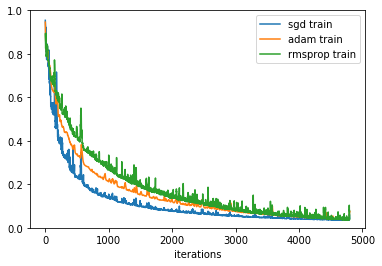

In [84]:
plt.plot(sgdtr)
plt.plot(adamtr)
plt.plot(rmsproptr)
# plt.plot(sgdte)
# plt.plot(adamte)
# plt.plot(rmspropte)
plt.ylim(0, 1)
plt.legend(['sgd train','adam train','rmsprop train'])
plt.xlabel('iterations')
plt.savefig('res_Linear_3tr.png')
#plt.plot(sgdtr)

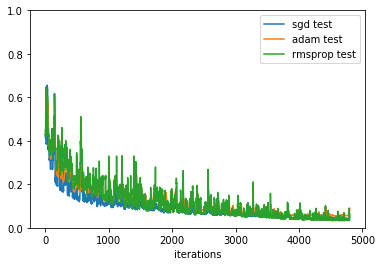

In [85]:
plt.plot(sgdte)
plt.plot(adamte)
plt.plot(rmspropte)
plt.ylim(0, 1)
plt.legend(['sgd test','adam test','rmsprop test'])
plt.xlabel('iterations')
plt.savefig('res_Linear_3te.png')

Text(0.5, 0, 'iterations')

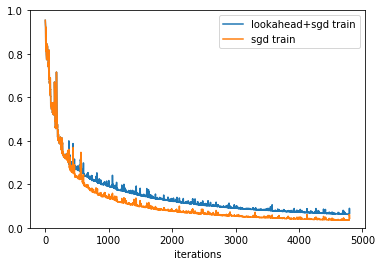

In [86]:

plt.plot(LAsgdtr)
#plt.plot(LAsgdte)
plt.plot(sgdtr)
#plt.plot(sgdte)
plt.ylim(0, 1)
#plt.legend(['lookahead+sgd train','lookahead+sgd test','sgd train','sgd test'])
plt.legend(['lookahead+sgd train','sgd train'])
plt.xlabel('iterations')
#plt.savefig('batch10calNNsgd.png')
# plt.plot(LAadamtr)
# plt.plot(adamtr)
# plt.legend(['lookahead+adam','adam'])
# plt.xlabel('iterations')

# plt.plot(LArmsproptr)
# plt.plot(rmsproptr)
# plt.legend(['lookahead+rmsprop','rmsprop'])
# plt.xlabel('iterations')
#plt.show()
#plt.savefig('batchsize200MNIST.png')

Text(0.5, 0, 'iterations')

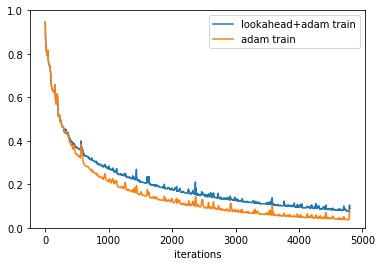

In [87]:
plt.plot(LAadamtr)
#plt.plot(LAadamte)
plt.plot(adamtr)
#plt.plot(adamte)
plt.ylim(0, 1)
#plt.legend(['lookahead+adam train','lookahead+adam test','adam train','adam test'])
plt.legend(['lookahead+adam train','adam train'])
plt.xlabel('iterations')
#plt.savefig('batch10calNNadam.png')

Text(0.5, 0, 'iterations')

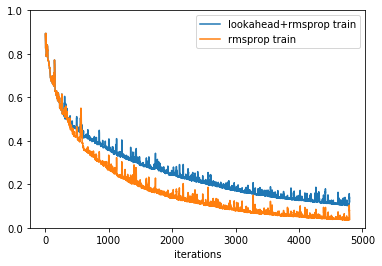

In [88]:
plt.plot(LArmsproptr)
#plt.plot(LArmspropte)
plt.plot(rmsproptr)
#plt.plot(rmspropte)

plt.ylim(0, 1)
#plt.legend(['lookahead+rmsprop train','lookahead+rmsprop test','rmsprop train','rmsprop test'])
plt.legend(['lookahead+rmsprop train','rmsprop train'])
plt.xlabel('iterations')
#plt.savefig('batch10calNNrmsprop.png')